In [1]:
# The code was removed by Watson Studio for sharing.

# Dados abertos e Ciência de Dados: Análise da actividade parlamentar das XIV Legislatura do Parlamento Português

_Frederico Muñoz_

## Introdução

O posicionamento absoluto e relativo dos vários partidos políticos no Parlamento português tem sido motivo de interesse redobrado nos últimos anos. A eleição de deputados de partidos sem anterior presença parlamentar tem alimentado o debate cujas implicações ideológicas foram vísiveis de forma bastante prática na problemática em torno da escolha de lugares: partidos desagradados com o lugar atribuído _(“Iniciativa Liberal Descontente Com Lugar Atribuído a Deputado No Parlamento - TSF” 2020)_, dificuldades gerais em termos de arrumação dos deputados _(Renascença 2019)_, questões de ordem mais ou menos prática em torno de acessos (Almeida 2019), enfim, várias dimensões para uma questão que acaba por revelar a importância simbólica do posionamento absoluto e relativo de cada partido no hemiciclo.

Esta questão não é particularmente nova _(Lourenço 2020)_, colocando-se em maior ou em menor grau com a entrada de novos partidos e a consequente necessidade de tomada de posição por parte do recém-chegado partido e a harmonização (possível) com os restantes, sendo que a sua posterior actividade parlamentar (nas suas diversas vertentes) poderá ou não alinhar-se com a sua auto-identificação (reflectida ou não nos lugares no hemiciclo).

O ponto de partida para esta análise foi precisamente tentar descobrir se exclusivamente com base na actividade parlamentar, e em concreto no registo de votações, é possível estabelecer relações de proximidade e distância que permitam um agrupamento que não dependa de classificações a priori, e se sim, de que forma estes agrupamentos confirmam ou divergem da percepção existente?

A utilização de dados abertos disponibilizados pelo Parlamento torna esta análise substancialmente mais simples, embora não sem a necessidade de tratamento e validação dos dados; de um ponto de vista prático este bloco de notas demonstra como aceder e transformar os dados de uma forma que pode ser útil para outras análises. No cenário nacional referência para a iniciativa http://hemiciclo.pt que, em linha com iniciativas europeias semelhantes, fornecesse um interface para um maior escrutinio da actividade parlamentar e um conjunto alargado de indicadores directos e indirectos do maior interesse _(Sapage 2020)_. O presente trabalho tem alguns pontos de contacto com esta iniciativa, dentro dos limites que o seu objectivo pedagógico estabelece.

A combinação de dados abertos com um bloco de notas Jupyter permite que o leitor tenha visibilidade dos vários passos e transformações _(Randles et al. 2017)_, o que pode por vezes apresentar uma excessiva complexidade paa quem não tenha familiaridade com programação; tentámos obviar esta limitação através da descrição das várias acções de forma a que se possa seguir a lógica e fruir dos resultados. Esta transparência assume uma dimensão adicional tendo em conta a temática que nos proposmos analisar, embora seja importante de forma tranversal (sobre a importância da repetibilidade, rastreabilidade, acesso e o papel de blocos Jupyter no contexto de open science ver, entre outros, exemplos em ecologia _(Powers and Hampton 2019)_ astronomia _(Wofford et al. 2019)_).

## Metodologia

Com base nos dados disponibilizados pela Assembleia da República em formato XML _(“Dados Abertos” 2020)_ são criadas _dataframes_ (tabelas de duas dimensões) com base no processamento e selecção de informação relativa aos padrões de votação de cada partido (e/ou deputados não-inscritos).

São fundamentalmente feitas as seguintes análises:

1. Vista geral das votações de cada partido, visualizado através de um _heatmap_
2. Matriz de distância euclidiana entre todos os partidos e visualização de _clustering_ hierárquico através de um dendograma e método de Ward.
3. Identificação de grupos (_clustering_) por DBSCAN e _Spectral Clustering_, com criação de matriz de afinidade
4. Redução das dimensões e visualização das distâncias e agrupamentos num espaço cartesiano a duas e três dimensões através de _Multidimensional Scaling_ (MDS)

A utilidade deste tipo de análise em ciência política é reconhecida _(Figueiredo Filho et al. 2014)_ e tem sido aplicada a vários registos de votações; a análise presente tem como principal diferença o ser efectuado sobre as votações de partidos e não, como é mais comum na bibliografia consultada, a deputados individuais.

O tratamento prévio dos dados em formato XML é feito de forma a seleccionar as votações de cada partido (ou deputado não inscrito), num processo com alguma complexidade que é por isso detalhado em secção própria do Apêndice

A informação é obtida a partir das listas publicadas de votações relativas a

- Actividades
- Iniciativas

Os dados utilizados são um subconjuntos dos disponibilizados, sendo que qualquer erro ou omissão nos dados originais irá ter imediato reflexo nos resultados das análises.

Este trabalho não tem como objectivo principal apenas mostrar os resultados finais, mas também (ou fundamentalmente) todo o processo comum em _Data Science_ para que se chegue até eles; é por isso pleno de blocos de código que tentámos contextualizar com descrições que tornem a sua compreensão dispensável para a quem não interessem esss detalhes, ao mesmo tempo que desviámos para secções do Apêndice discussões mais extensas de vários passos. Requer, ainda assim, algum esforço em termos de seguir o caminho (por vezes pejado de desvios, atalhos e retrocessos) até aos diversos resultados apresentados.

**NB**
O processo de tratamento de dados não é indiferente para o resultado final: _são feitas escolhas a vários níveis (desde a selecção dos dados considerados importantes aos algoritmos escolhidos) que têm impacto nos resultados, nem que seja por omissão_. Mais do que evitá-lo (o que não seria possível), optámos por identificar de forma clara as escolhas feitas e explicar as razões que levaram à sua escolha: cada leitor poderá assim determinar a razoabilidade de cada uma e, sobretudo, ensaiar novas formas que considere mais adequadas.

## Instalação de pré-requisitos

Como primeiro passo definimos alguns valores que deverão ser utilizados pelo bloco de notas Jupyter para exibir tabelas e diagramas; instalamos o pacote `itables` que nos permite uma visualização mais interactiva em modo de edição:

In [102]:
%matplotlib inline

#import itables.interactive
#import itables.options as opt
!pip install -q  itables
from itables import show
import itables.options as opt

opt.maxColumns=100
opt.maxRows=2000
opt.lengthMenu = [10, 20, 50, 100, 200, 500]


## Obtenção, limpeza e tratamento dos dados


Esta fase é fundamental para toda a restante análise: é onde obtemos os dados e os transformamos em informação num formato que pode ser facilmente manipulado.

### Obtenção do ficheiro

Na página do Parlamento podem ser obtidos, para cada legislatura, ficheiros em formato JSON ou XML com a informação relativa a cada "área temática". Para a XIV Legislatura estamos interessados em duas dessas áreas:

- **Iniciativas:** _"...Da lista de tipo de Iniciativas entradas, constam Projetos e Propostas de Lei, Projetos e Propostas de Resolução, Apreciações Parlamentares, Inquéritos Parlamentares, Projetos de Revisão Constitucional, Projetos de Deliberação, Projetos de Regimento, Ratificações, sendo as mais usuais, projetos de lei que são apresentados por Deputados, Grupos Parlamentares ou um grupo de cidadãos, e as propostas de lei apresentadas pelo Governo e pelas Assembleias Legislativas das Regiões Autónomas."_
- **Actividades:** _"...Consideram-se Atividades Parlamentares as seguintes atividades: Apreciação de relatórios entregues por entidades externas, Audiências, Audições, Cerimónias, Conta Geral do Estado, Debates, Declarações Políticas, Defesa Nacional, Deslocações no âmbito das Comissões, Deslocações do Presidente da República, Eleição e composição para órgãos externos, Eventos no âmbito de Comissões, Grandes Opções do Conceito Estratégico da Defesa Nacional, Interpelações ao Governo, Moções, Orçamento e Conta de Gerência da AR, Orientação da Política Orçamental, Perguntas ao Governo, Programa de Estabilidade e Crescimento, Programa do Governo, Relatórios de Segurança Interna, Segurança Interna, Votos."_

Estas áreas concentram a maioria (se não a totalidade) das votações dos partidos, algo que tendo em conta o objectivo é fundamental: para a análise proposta só interessam eventos onde seja possível extraír a informação da votação, e dentro destes (como veremos) os que sejam directamente imputáveis a partidos.

Començando pelas **iniciativas parlamentares**, definimos o URL da versão em XML do ficheiro; para o processamento deste formato usaremos `Element.Tree`, uma das opções em Python para este fim que vem incluída de base, pelo que o seguinte bloco descarrega o ficheiro e converte-o numa "árvore" (onde os "ramos" e as "folhas" são subdivisões da informação dado o formato hierárquico)


In [3]:
from urllib.request import urlopen
import xml.etree.ElementTree as ET

ini_url = 'http://app.parlamento.pt/webutils/docs/doc.xml?path=6148523063446f764c324679626d56304c3239775a57356b595852684c3052685a47397a51574a6c636e52766379394a626d6c6a6157463061585a68637939595356596c4d6a424d5a57647063327868644856795953394a626d6c6a6157463061585a686331684a566935346257773d&fich=IniciativasXIV.xml&Inline=true'
ini_tree = ET.parse(urlopen(ini_url))

### Formato XML via Element.Tree, autoria das iniciativas e transformações preliminares

Esta árvore pode ser visualizada abrindo o ficheiro original num editor de código que o formate de forma adequada (nomeadamente através de indentação dos blocos); trata-se de um ficheiro relativamente grande (~30 MB) e tem um conteúdo estruturado da forma habitual para o formato como pode ser observado na seguinte extracção das primeiras linhas:

In [4]:
## Import BeautifulSoup for the pretty-priting
from bs4 import BeautifulSoup

## Get a string with the XML from the root down
xmlstr = ET.tostring(ini_tree.getroot(), encoding='utf8', method='xml')

## Print the first 300 charaters; note that extra tags will be added to make the output "valid"
print(BeautifulSoup(xmlstr[0:300], "xml").prettify())

<?xml version="1.0" encoding="utf-8"?>
<ArrayOfPt_gov_ar_objectos_iniciativas_DetalhePesquisaIniciativasOut>
 <pt_gov_ar_objectos_iniciativas_DetalhePesquisaIniciativasOut>
  <iniNr>
   28
  </iniNr>
  <iniTipo>
   A
  </iniTipo>
  <iniDescTipo>
   Apreciação Parlamentar
  </iniDescTipo>
  <iniLeg>
   XIV
  </iniLeg>
  <iniSel>
   1
  </iniSel>
  <data/>
 </pt_gov_ar_objectos_iniciativas_DetalhePesquisaIniciativasOut>
</ArrayOfPt_gov_ar_objectos_iniciativas_DetalhePesquisaIniciativasOut>


O código final é o resultado final de um processo de estudo do formato (com tentativas, avanços e recuos) mas, em termos gerais, o seguinte bloco diz-nos que:

- A variável `ini_tree` é do tipo `xml.etree.ElementTree.ElementTree`
- Na raíz da árvore está um conjunto (`array`) de elementos
- Esses elementos têm a etiqueta `pt_gov_ar_objectos_iniciativas_DetalhePesquisaIniciativasOut`

Por sua vez estes últimos elementos são constituidos por mais "ramos" e "folhas" que contém informação sobre a iniciativa: quem a propôs, a fases, as votações e os seus resultados, etc.

In [107]:
print(type(ini_tree))
print(ini_tree.findall("."))
counter = 0
for initiative in ini_tree.findall('.')[0]:
    ## Only provide an example of the first lines
    if counter < 5:
        print(initiative)
    counter += 1

<class 'xml.etree.ElementTree.ElementTree'>
[<Element 'ArrayOfPt_gov_ar_objectos_iniciativas_DetalhePesquisaIniciativasOut' at 0x7fa6aa3ac598>]
<Element 'pt_gov_ar_objectos_iniciativas_DetalhePesquisaIniciativasOut' at 0x7fa6aa3ac5e8>
<Element 'pt_gov_ar_objectos_iniciativas_DetalhePesquisaIniciativasOut' at 0x7fa6aa3c22c8>
<Element 'pt_gov_ar_objectos_iniciativas_DetalhePesquisaIniciativasOut' at 0x7fa6a9ec6f48>
<Element 'pt_gov_ar_objectos_iniciativas_DetalhePesquisaIniciativasOut' at 0x7fa6a9ecb598>
<Element 'pt_gov_ar_objectos_iniciativas_DetalhePesquisaIniciativasOut' at 0x7fa6a9ece778>


O total de iniciativas é-nos dados pelo valor acumulado no bloco anterior:

In [6]:
print("Total de iniciativas contidas na árvore: ", counter)

Total de iniciativas contidas na árvore:  1280


Dada a importância para o objectivo proposto é útil descrever o elemento `pt_gov_ar_objectos_VotacaoOut` que contém a informação sobre votações; podemos começar por contar as entradas na árvore:

In [109]:
counter = 0
for c in ini_tree.findall(".//pt_gov_ar_objectos_VotacaoOut"):
    print('.', end='')
    counter += 1

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Tal como anteriormente o acumulador indica-nos o total, neste caso de votações:

In [110]:
print("Total de votações contidas na árvore: ", counter)

Total de votações contidas na árvore:  1730


O seguinte bloco encontra _apenas a primeira ocorrência_, para simplificar a discussão dos dados apenas a um caso:

In [111]:
## Get the first occurence of a "VotacaoOut" entry
for c in ini_tree.find(".//pt_gov_ar_objectos_VotacaoOut"):
    print("{0:15}: {1}".format(c.tag,c.text))

id             : 88184
resultado      : Aprovado
descricao      : Texto Final apresentado pela Comissão de Administração Pública, Modernização Administrativa, Descentralização e Poder Local relativo às Apreciações Parlamentares n.ºs 21/XIV/1.ª (PSD); 22/XIV/1.ª (BE); e 23/XIV/1.ª (PCP)
reuniao        : 76
tipoReuniao    : RP
detalhe        : A Favor: <I>PS</I>, <I>PSD</I><BR>Contra: <I>BE</I>, <I>PCP</I>, <I>CDS-PP</I>, <I>PAN</I>, <I>PEV</I>, <I>CH</I>, Cristina Rodrigues (Ninsc), Joacine Katar Moreira (Ninsc)<BR>Abstenção: <I>IL</I>


Note-se para já que existe informação que não está presente (nomeadamente a autoria); a autoria da _iniciativa_ pode ser determinada facilmente mas não se relaciona de forma directa com a autoria da matéria em votação, e existem iniciativas sem votações associadas (cf. [Iniciativas e votações](#Iniciativas-e-votações))


### Votações: de descrição textual a informação estruturada

É  importante notar que o o resultado da votação está em "texto livre", o que nos remete para a diferença entre dados estruturados e não-estruturados  [DataStructureData2018]; de forma simples significa que antes de podermos utilizar os dados temos de os transformar pois o que temos no campo `detalhe` não pode ser usado sem ser convertido numa tabela com o par _partido/votação_ 

In [112]:
## Find the first instance of VotacaoOut
for c in ini_tree.find(".//pt_gov_ar_objectos_VotacaoOut"):
        print("\t{0:15}: {1}".format(c.tag, c.text))

	id             : 88184
	resultado      : Aprovado
	descricao      : Texto Final apresentado pela Comissão de Administração Pública, Modernização Administrativa, Descentralização e Poder Local relativo às Apreciações Parlamentares n.ºs 21/XIV/1.ª (PSD); 22/XIV/1.ª (BE); e 23/XIV/1.ª (PCP)
	reuniao        : 76
	tipoReuniao    : RP
	detalhe        : A Favor: <I>PS</I>, <I>PSD</I><BR>Contra: <I>BE</I>, <I>PCP</I>, <I>CDS-PP</I>, <I>PAN</I>, <I>PEV</I>, <I>CH</I>, Cristina Rodrigues (Ninsc), Joacine Katar Moreira (Ninsc)<BR>Abstenção: <I>IL</I>


O texto contido no `detalhe` tem informação descritiva que contém formatação HTML. É necessário processar o texto de forma a poder criar uma tabela que associe a cada partido (ou deputado não-inscrito) o seu sentido de voto. Este processamento seria simples se existisse sempre uma única forma de descrever as votações, o que não acontece.

#### Partidos e deputados na determinação do sentido de voto

O tratamento e transformação de dados é um processo que por vezes parece estar sempre inacabado; seja 80% do tempo gasto _(“Cleaning Big Data: Most Time-Consuming, Least Enjoyable Data Science Task, Survey Says” 2020)_ ou menos _(Dodds 2020)_ tem sempre uma importância fundamental. Até agora cobrimos já vários aspectos que nos colocam muito próximos da utilização dos dados de forma estruturada, mas ainda restam detalhes fundamentais.

Um ponto importante a relembrar: a metodologia adoptada e os objectivos da análise prendem-se com o posionamento relativo de partidos políticos, por via dos seus grupos parlamentares ou deputados individuais, e não com o perfil de votação de cada deputado. O sistema parlamentar português assenta na representatividade por via de eleição de deputados eleitos por partidos mas os deputados votam de forma individual. Com variações dependendo dos partidos. A chamada "disciplina partidária" é a regra, por razões que não são únicas do sistema político português _(Jackson 1968)_.

Esta realidade está presente na forma como os votos são apresentados por partidos nos registos oficiais mas apresenta também excepções importantes:

1. **Votações nominais onde todos os votos são descritos de forma individual.**
2. **Votações onde existem votos de deputados diferentes do seu grupo** sendo apresentados de forma nominal.
3. **Votações onde existem votos de deputados diferentes do seu grupo***, apresentados como um número total de deputados do grupo com esse sentido divergente.
4. **Votações onde os votos são indicados sem excepções**, sendo este o caso mais comum e também mais simples de cobrir.

Nos três primeiros casos não é imediata a posição de cada partido, e uma opção seria excluir estas votações completamente. Outra opção, e a que escolhemos, foi o de **determinar o sentido de voto com base na maioria dos votos**.

O reduzido número de votações por este método tornam esta decisão de impacto reduzido, mas não deixa de existir: olhando para as votações relativas à eutanásia é conhecida a forma diferenciada como foi votada. A sua eliminação iria, por exemplo, omitir dados que afastam a IL do CDS-PP e CHEGA, à direita, e o PCP do PEV e BE, à esquerda. _O reduzido número de casos não deve remover a necessidade de se assumir a possibilidade do impacto ser relevante quando mais à frente verificarmos que a distância relativa de partidos (em particular à direita) é muito semelhante_, o que torna qualquer observação adicional passível de impactar o agrupamento e particularmnte o dendograma, razão pela qual considerámos adequada a decisão de extrapolar a decisão da maioria dos deputados de um partido como indicador da posição do partido.

Os detalhes do processamento para cada tipo de votação é discutido em detalhe no apêndice [Processamento da descrição de votos](#Processamento-da-descrição-de-votos), com os respectivos exemplos. O seguinte bloco de código é o resultado final do tratamento dos vários casos:

In [11]:
from bs4 import BeautifulSoup
import re

## Iteract through the existing dict
def party_from_votes (votes):
    """
    Determines the position of a party based on the majority position by summing all the individual votes.
    Argument is a dictionary returned by parse_voting()
    Returns a dictionary with the majority position of each party
    """
    party_vote = {}
    for k, v in votes.items():
        ## Erase the name of the MP and keep the party only
        ## only when it's not from the "Ninsc" group - 
        ## these need to be differentiated by name
        if re.match(".*\(Ninsc\)" , k) is None:
            nk = re.sub(r".*\((.+?)\).*", r"\1", k)
        else:
            nk = k
        ## If it's the first entry for a key, create it
        if nk not in party_vote:
            party_vote[nk] = [0,0,0]
        ## Add to a specific index in a list
        if v == "A Favor":
            party_vote[nk][0] += 1
        elif v == "Abstenção":
            party_vote[nk][1] += 1
        elif v == "Contra":
            party_vote[nk][2] += 1
    for k,v in party_vote.items():
        party_vote[k]=["A Favor", "Abstenção", "Contra"][v.index(max(v))]
    return party_vote

def parse_voting(v_str):
    """Parses the voting details in a string and returns a dict.
    
    Keyword arguments:
    
    v_str: a string with the description of the voting behaviour.
    """
    ## Split by the HTML line break and put it in a dict
    d = dict(x.split(':') for x in v_str.split('<BR>'))
    ## Remove the HTML tags
    for k, v in d.items():
        ctext = BeautifulSoup(v, "lxml")
        d[k] = ctext.get_text().strip().split(",")
    ## Invert the dict to get a 1-to-1 mapping
    ## and trim it
    votes = {}
    if len(v_str) < 1000:    # Naive approach but realistically speaking... works well enough.
        for k, v in d.items():
            for p in v:
                if (p != ' ' and                                       # Bypass empty entries
                    re.match("[0-9]+", p.strip()) is None and           # Bypass quantified divergent voting patterns
                    (re.match(".*\w +\(.+\)", p.strip()) is None or     # Bypass individual votes...
                     re.match(".*\(Ninsc\)" , p.strip()) is not None)): # ... except when coming from "Ninsc"
                        #print("|"+ p.strip() + "|" + ":\t" + k)
                        votes[p.strip()] = k
    else:  # This is a nominal vote since the size of the string is greater than 1000
        for k, v in d.items():
            for p in v:
                if p != ' ':
                    votes[p.strip()] = k
        ## Call the auxiliary function to produce the party position based on the majority votes
        votes = party_from_votes(votes)
    return votes


O resultado da votação nominal relativa à eutanásia que foi dada como primeiro exemplo é simplificado e apresenta a votação maioritária de cada partido como aquela que será considerada (um tratamento semelhante, por simples omissão, é dado às restantes variações):

In [12]:
for v in ini_tree.find(".//pt_gov_ar_objectos_VotacaoOut/[id='86004']"):
    if v.tag == "detalhe":
        print("\t{0:15}: {1}".format(v.tag,parse_voting(v.text)))
    else:
        print("\t{0:15}: {1}".format(v.tag,v.text))

	id             : 86004
	resultado      : Aprovado
	reuniao        : 32
	tipoReuniao    : RP
	detalhe        : {'PS': 'A Favor', 'PSD': 'Contra', 'BE': 'A Favor', 'PAN': 'A Favor', 'Joacine Katar Moreira (Ninsc)': 'A Favor', 'IL': 'A Favor', 'PCP': 'Contra', 'CDS-PP': 'Contra', 'CH': 'Contra', 'PEV': 'Abstenção'}


#### Deputados não-inscritos

Existe um tratamento especial no código para os deputados não-inscritos de forma a evitar que nestes casos seja removido o nome; recentemente foram aprovadas alterações que permitem a diferenciação de forma mais clara entre as duas deputadas não-inscritas _(Lusa 2020a)_  mas que não se aplicam retroactivamente aos dados existentes.

Esta situação leva a que seja necessário diferenciar pelo nome, caso contrário na seguinte votação seriam contabilizados votos para um grupo/partido _"Ninsc"_, o que não faria sentido.

In [13]:
## Example of vote where two MPs which are not registered with a party would
## be grouped under a generic "Unregistered" group
for v in ini_tree.find(".//pt_gov_ar_objectos_VotacaoOut/[id='88184']"):
    if v.tag == "detalhe":
        print("\t{0:15}: {1}".format(v.tag,parse_voting(v.text)))
    else:
        print("\t{0:15}: {1}".format(v.tag,v.text))

	id             : 88184
	resultado      : Aprovado
	descricao      : Texto Final apresentado pela Comissão de Administração Pública, Modernização Administrativa, Descentralização e Poder Local relativo às Apreciações Parlamentares n.ºs 21/XIV/1.ª (PSD); 22/XIV/1.ª (BE); e 23/XIV/1.ª (PCP)
	reuniao        : 76
	tipoReuniao    : RP
	detalhe        : {'PS': 'A Favor', 'PSD': 'A Favor', 'BE': 'Contra', 'PCP': 'Contra', 'CDS-PP': 'Contra', 'PAN': 'Contra', 'PEV': 'Contra', 'CH': 'Contra', 'Cristina Rodrigues (Ninsc)': 'Contra', 'Joacine Katar Moreira (Ninsc)': 'Contra', 'IL': 'Abstenção'}


## Criação do _dataframe_

Após estes vários desvios (fundamentais para que se consiga produzir o resultado necessário) voltamos à representação em árvore que resulta da interpretação do formato XML da votação e com o auxílio das várias funções á entretanto definidas criamos um modelo tabular de todas as votações.

In [113]:
import collections

root = ini_tree

counter=0

## We will build a dataframe from a list of dicts
## Inspired by the approach of Chris Moffitt here https://pbpython.com/pandas-list-dict.html
init_list = []

for voting in ini_tree.findall(".//pt_gov_ar_objectos_VotacaoOut"):
    votep = voting.find('./detalhe')
    if votep is not None:
        init_dict = collections.OrderedDict()
        counter +=1                 
        init_dict['id'] = voting.find('id').text
        ## Add the "I" for Type to mark this as coming from "Iniciativas"
        init_dict['Tipo'] = "I"
        for c in voting:
            if c.tag == "detalhe":
                for party, vote in parse_voting(c.text).items():
                    init_dict[party] = vote 
            elif c.tag == "descricao":
                    init_dict[c.tag] = c.text
            elif c.tag == "ausencias":
                    init_dict[c.tag] = c.find("string").text
            else:
                    init_dict[c.tag] = c.text
        init_list.append(init_dict)
    ## Provide progression feedback
    print('.', end='')
        
print(counter)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

O processamento criou uma lista de dicionários que convertemos numa _dataframe_ Pandas. Note-se como várias votações não têm o campo `descricao`: obter a informação do título da iniciativa seria uma opção possivel para permitir adicionar contexto a estes casos, mas como referido, não sendo tal necessário para os objectivos imediatos deste trabalho, optou-se por simplificar o código e omitir essa informação (ver [Informação adicional da iniciativa](#Informação-adicional-da-iniciativa)  para um exemplo)

In [123]:
import pandas as pd

ini_df = pd.DataFrame(init_list)
print(ini_df.shape)
ini_df.head()

(1723, 20)


,id,Tipo,resultado,descricao,reuniao,tipoReuniao,PS,PSD,BE,PCP,CDS-PP,PAN,PEV,CH,Cristina Rodrigues (Ninsc),Joacine Katar Moreira (Ninsc),IL,unanime,L,ausencias
0,88184,I,Aprovado,Texto Final apresentado pela Comissão de Admin...,76,RP,A Favor,A Favor,Contra,Contra,Contra,Contra,Contra,Contra,Contra,Contra,Abstenção,NaN,NaN,NaN
1,88183,I,Aprovado,Texto Final apresentado pela Comissão de Admin...,76,RP,A Favor,A Favor,Contra,Contra,Contra,Contra,Contra,Contra,Contra,Contra,Abstenção,NaN,NaN,NaN
2,88181,I,Aprovado,Texto Final apresentado pela Comissão de Admin...,76,RP,A Favor,A Favor,Contra,Contra,Contra,Contra,Contra,Contra,Contra,Contra,Abstenção,NaN,NaN,NaN
3,87725,I,Aprovado,Texto Final apresentado pela Comissão de Saúde...,68,RP,Contra,A Favor,A Favor,A Favor,A Favor,A Favor,A Favor,A Favor,A Favor,A Favor,A Favor,NaN,NaN,NaN
4,88346,I,Aprovado,Texto Final apresentado pela Comissão de Assun...,76,RP,Contra,A Favor,A Favor,A Favor,A Favor,A Favor,A Favor,A Favor,A Favor,A Favor,A Favor,NaN,NaN,NaN


A tabela contém 1723 linhas (o número de votações que tinhamos já observado) e 20 colunas; cada "caso" equivale a uma votação com os dados respectivos indicados pelas colunas, como pode ser observado tomando o primeiro caso como exemplo:

In [16]:
ini_df.loc[0]

id                                                                           88184
Tipo                                                                             I
resultado                                                                 Aprovado
descricao                        Texto Final apresentado pela Comissão de Admin...
reuniao                                                                         76
tipoReuniao                                                                     RP
PS                                                                         A Favor
PSD                                                                        A Favor
BE                                                                          Contra
PCP                                                                         Contra
CDS-PP                                                                      Contra
PAN                                                                         Contra
PEV 

Nem todos os campos estão preenchidos em todas as votações, o que é normal visto nem todos os campos serem obrigatórios.

### Não-inscritos e a necessidade de processamento adicional

Já anteriormente o tratamento dos "não inscritos" levou à necessidade de pré-processamento; agora que já temos a estrutura de dados num _dataframe_ é também necessário proceder a alguns passos de pós-processamento que surgem após uma leitura supercicial da tabela acima.

Existem dois casos que precisam ser analisados de forma individual; na secção [Processamento adicional dos não-inscritos](#Processamento-adicional-dos-não-inscritos) do apêndice detalhamos a informação que levou à decisão tomada e que é a seguinte:

- Agrupar os dados do Livre e da deputada Joacine Katar Moreira, por ser deputada única e assim existir uma continuidade em termos do registo de votação.
- Não includir a deputada Cristina Rodrigues na comparação global dado o limitado número de votações.

O seguinte bloco cria uma nova coluna, `L/JKM`, composta da sobreposição dos votos de ambos.

In [17]:
## Copy Livre voting record to new aggregate columns...
ini_df["L/JKM"] = ini_df["L"]
## ... and fill the NAs with JKM voting record.
ini_df["L/JKM"] = ini_df["L/JKM"].fillna(ini_df["Joacine Katar Moreira (Ninsc)"])
ini_df[["descricao","L","Joacine Katar Moreira (Ninsc)","L/JKM"]].head()

,descricao,L,Joacine Katar Moreira (Ninsc),L/JKM
0,Texto Final apresentado pela Comissão de Admin...,NaN,Contra,Contra
1,Texto Final apresentado pela Comissão de Admin...,NaN,Contra,Contra
2,Texto Final apresentado pela Comissão de Admin...,NaN,Contra,Contra
3,Texto Final apresentado pela Comissão de Saúde...,NaN,A Favor,A Favor
4,Texto Final apresentado pela Comissão de Assun...,NaN,A Favor,A Favor


Processo semelhante aplicamos à deputada Cristina Rodrigues para podermos fazer uma análise específica (tal como no caso anterior apresentamos apenas as primeiro 5 linhas da tabela gerada para facilidade de leitura):

In [118]:
## Copy PAN voting record to new aggregate columns...
ini_df["PAN/CR"] = ini_df["PAN"]
## ... and update/replace with CR voting where it exists
ini_df["PAN/CR"].update(ini_df["Cristina Rodrigues (Ninsc)"])
ini_df[["descricao","PAN","Cristina Rodrigues (Ninsc)","PAN/CR"]].head()


,descricao,PAN,Cristina Rodrigues (Ninsc),PAN/CR
0,Texto Final apresentado pela Comissão de Admin...,Contra,Contra,Contra
1,Texto Final apresentado pela Comissão de Admin...,Contra,Contra,Contra
2,Texto Final apresentado pela Comissão de Admin...,Contra,Contra,Contra
3,Texto Final apresentado pela Comissão de Saúde...,A Favor,A Favor,A Favor
4,Texto Final apresentado pela Comissão de Assun...,A Favor,A Favor,A Favor


### Processamento de Actividades

Até agora trabalhámos sobre _iniciativas_; existe uma fonte adicional de informação (contida num ficheiro separado e com uma estrutura semelhante mas nao idêntica) relativa às _Actividades Parlamentares_, onde também se incluém votações.

Toda a discussão e código de processamento feito pode ser aplicado pelo que não iremos repetir as considerações já feitas; o processo de obtenção do XML é idêntico:

In [19]:
act_url = 'http://app.parlamento.pt/webutils/docs/doc.xml?path=6148523063446f764c324679626d56304c3239775a57356b595852684c3052685a47397a51574a6c636e52766379394264476c32615752685a47567a4c31684a566955794d45786c5a326c7a6247463064584a684c30463061585a705a47466b5a584e595356597565473173&fich=AtividadesXIV.xml&Inline=true'
act_tree = ET.parse(urlopen(act_url))

O processamento também o é, com a diferença de que adicionamos um campo `descricao` que é na verdade obtido a partir do assunto da actividade.

In [20]:
import re
import collections

root = act_tree

counter=0

## We will build a dataframe from a list of dicts
## Inspired by the approach of Chris Moffitt here https://pbpython.com/pandas-list-dict.html
act_list = []

def get_toplevel_desc (vid, tree):
    """
    Gets the top-level title from a voting id
    """
    for c in tree.find(".//pt_gov_ar_objectos_VotacaoOut/[id='"+ vid +"']/../.."):
        if c.tag == "assunto":
            return c.text

for voting in act_tree.findall(".//pt_gov_ar_objectos_VotacaoOut"):
    act_dict = collections.OrderedDict()
    counter +=1
    votep = voting.find('./detalhe')
    if votep is not None:
        act_dict['id'] = voting.find('id').text
        ## Add the "A" for Type to mark this as coming from "Iniciativas"
        act_dict['Tipo'] = "A"
        for c in voting:
            if c.tag == "id":
                act_dict['descricao'] = get_toplevel_desc(c.text, act_tree)
            if c.tag == "detalhe":
                for party, vote in parse_voting(c.text).items():
                    act_dict[party] = vote 
            elif c.tag == "ausencias":
                    act_dict[c.tag] = c.find("string").text
            else:
                    act_dict[c.tag] = c.text
        act_list.append(act_dict)
    ## Provide progression feedback
    print('.', end='')

print(counter)

........................................................................................................................................................................................................................................232


Criamos também um _dataframe_ com base na informação recolhida:

In [124]:
act_df = pd.DataFrame(act_list)
print(act_df.shape)

act_df.head()

(211, 21)


,id,Tipo,descricao,resultado,reuniao,unanime,PS,PSD,BE,PCP,...,PAN,PEV,CH,IL,Cristina Rodrigues (Ninsc),Joacine Katar Moreira (Ninsc),publicacao,data,ausencias,L
0,88158,A,Pelo falecimento de António Franco,Aprovado,76,unanime,A Favor,A Favor,A Favor,A Favor,...,A Favor,A Favor,A Favor,A Favor,A Favor,A Favor,NaN,2020-07-23,NaN,NaN
1,88157,A,De pesar pela morte em serviço dos bombeiros F...,Aprovado,76,unanime,A Favor,A Favor,A Favor,A Favor,...,A Favor,A Favor,A Favor,A Favor,A Favor,A Favor,NaN,2020-07-23,NaN,NaN
2,88156,A,De pesar pelo falecimento de Luís Filipe Costa,Aprovado,76,unanime,A Favor,A Favor,A Favor,A Favor,...,A Favor,A Favor,A Favor,A Favor,A Favor,A Favor,NaN,2020-07-23,NaN,NaN
3,88155,A,De saudação ao Centenário de Amália Rodrigues,Aprovado,76,unanime,A Favor,A Favor,A Favor,A Favor,...,A Favor,A Favor,A Favor,A Favor,A Favor,A Favor,NaN,2020-07-23,NaN,NaN
4,87911,A,De pesar pelo falecimento do Maestro Mário Coelho,Aprovado,75,NaN,A Favor,A Favor,Abstenção,A Favor,...,Contra,A Favor,A Favor,A Favor,Abstenção,NaN,NaN,2020-07-10,NaN,NaN


É necessário aplicar o mesmo princípio relativo à agregação de votos do Livre e Joacine Katar Moreira, PAN e Cristina Rodrigues.

In [119]:
## Copy Livre voting record to new aggregate columns...
act_df["L/JKM"] = act_df["L"]
## ... and fill the NAs with JKM voting record.
act_df["L/JKM"] = act_df["L/JKM"].fillna(act_df["Joacine Katar Moreira (Ninsc)"])

## Copy PAN voting record to new aggregate columns...
act_df["PAN/CR"] = act_df["PAN"]
## ... and update/replace with CR voting where it exists
act_df["PAN/CR"].update(act_df["Cristina Rodrigues (Ninsc)"])
act_df[["descricao","PAN","Cristina Rodrigues (Ninsc)","PAN/CR"]].head()

,descricao,PAN,Cristina Rodrigues (Ninsc),PAN/CR
0,Pelo falecimento de António Franco,A Favor,A Favor,A Favor
1,De pesar pela morte em serviço dos bombeiros F...,A Favor,A Favor,A Favor
2,De pesar pelo falecimento de Luís Filipe Costa,A Favor,A Favor,A Favor
3,De saudação ao Centenário de Amália Rodrigues,A Favor,A Favor,A Favor
4,De pesar pelo falecimento do Maestro Mário Coelho,Contra,Abstenção,Abstenção


### Agregação das votações

Neste momento temos dois _dataframes_, um para as Iniciativas e outro para as Actividades; durante o processo de construção de ambos foi adicionada uma coluna `Tipo` que permite identificar, se necessário, a origem da votação.

No presente trabalho consideramos todas as votações de forma idêntica pelo que nos resta construir um _dataframe_ único que seja a junção dos existentes, tendo em consideração que as colunas de ambos não são exactamente as mesmas.

In [23]:
print(ini_df.sort_index(axis=1).columns)
print(act_df.sort_index(axis=1).columns)

Index(['BE', 'CDS-PP', 'CH', 'Cristina Rodrigues (Ninsc)', 'IL',
       'Joacine Katar Moreira (Ninsc)', 'L', 'L/JKM', 'PAN', 'PAN/CR', 'PCP',
       'PEV', 'PS', 'PSD', 'Tipo', 'ausencias', 'descricao', 'id', 'resultado',
       'reuniao', 'tipoReuniao', 'unanime'],
      dtype='object')
Index(['BE', 'CDS-PP', 'CH', 'Cristina Rodrigues (Ninsc)', 'IL',
       'Joacine Katar Moreira (Ninsc)', 'L', 'L/JKM', 'PAN', 'PAN/CR', 'PCP',
       'PEV', 'PS', 'PSD', 'Tipo', 'ausencias', 'data', 'descricao', 'id',
       'publicacao', 'resultado', 'reuniao', 'unanime'],
      dtype='object')


A concatenação dos dados é feita através da remoção das colunas diferentes.

In [24]:
votes = pd.concat([ini_df.drop(["tipoReuniao"],axis=1),act_df.drop(["data","publicacao"],axis=1)], sort=True)

Este último passo de processamento dá origem à tabela final que irá ser usada para as várias análises posteriores; o seu formato formato tabular pode servir de base para análises com outras ferramentas (ver [Conversão do _dataframe_ em CSV](#Conversão-do-_dataframe_em-CSV)).

In [25]:
print(votes.shape)
votes.columns

(1934, 21)


Index(['BE', 'CDS-PP', 'CH', 'Cristina Rodrigues (Ninsc)', 'IL',
       'Joacine Katar Moreira (Ninsc)', 'L', 'L/JKM', 'PAN', 'PAN/CR', 'PCP',
       'PEV', 'PS', 'PSD', 'Tipo', 'ausencias', 'descricao', 'id', 'resultado',
       'reuniao', 'unanime'],
      dtype='object')

## Exploração e visualização dos dados

Tendo a nossa fonte de dados devidamente construída podemos fazer algumas análises exploratórias com base em visualizações.

Para começar seria interessante podermos ter uma representação de alto-nível que apresentasse as votações de forma global. Para este fim um mapa térmico (_heatmap_) é uma opção.

Começamos por criar um novo _dataframe_ que contenha apenas o sentido de voto dos partidos que vamos analisar, removendo os campos adicionais. Esta acção poderia ser feita também por remoção de colunas: optamos pela especificação dos campos também porque nos permite colocar os vários partidos em "ordem", consoante a sua posição no parlamento _(“Estão Distribuídas (para Já) as Cadeiras No Parlamento - DN” 2020)_, o que facilita a localização e interpretação dos dados (e inclusivamente a maior ou menor pertinência dessa dimensão)

In [26]:
votes_hm = votes[['BE', 'PCP', 'PEV', 'L/JKM', 'PS', 'PAN','PSD','IL','CDS-PP', 'CH']]
votes_hm.head()

,BE,PCP,PEV,L/JKM,PS,PAN,PSD,IL,CDS-PP,CH
0,Contra,Contra,Contra,Contra,A Favor,Contra,A Favor,Abstenção,Contra,Contra
1,Contra,Contra,Contra,Contra,A Favor,Contra,A Favor,Abstenção,Contra,Contra
2,Contra,Contra,Contra,Contra,A Favor,Contra,A Favor,Abstenção,Contra,Contra
3,A Favor,A Favor,A Favor,A Favor,Contra,A Favor,A Favor,A Favor,A Favor,A Favor
4,A Favor,A Favor,A Favor,A Favor,Contra,A Favor,A Favor,A Favor,A Favor,A Favor


Este mapa apresenta os votos seguindo o seguinte esquema de cores:

- A Favor: verde
- Abstenção: amarelo
- Contra: vermelho
- Ausência/NA: preto

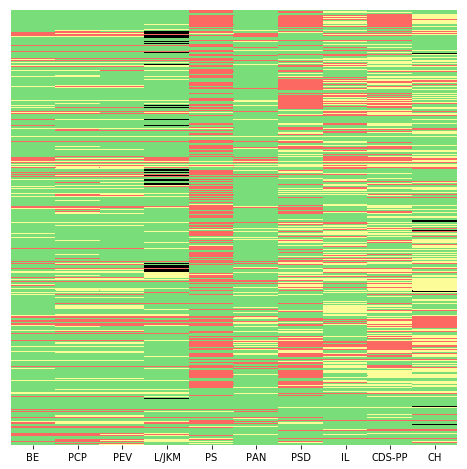

In [27]:

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

votes_hmn = votes_hm.replace(["A Favor", "Contra", "Abstenção", "Ausência"], [1,-1,0,2]).fillna(0)

voting_palette = ["#FB6962","#FCFC99","#79DE79", "black"]

fig = plt.figure(figsize=(8,8))
sns.heatmap(votes_hmn,
            square=False,
            yticklabels = False,
            cbar=False,
            cmap=sns.color_palette(voting_palette),
           )
plt.show()

Existem alguns pontos interessantes que podem ser observados desde já. Uma análise da origem das iniciativas e actividades a votação poderá confirmar ou desmentir estas observações:

1. **Uma maior tendência para votos "A Favor" à esquerda**

Pode relacionar-se com uma maior produção de propostas a votação.

2. **Uma notória diferenciação do PS na maior quantidade de votos Contra**

Enquanto partido que suporta o Governo, esta tendência pode relacionar-se com a anterior e representar o voto contra de propostas de outros partidos.

3. **Algum acompanhamento do PSD nos votos contra do PS**

Podem representar convergências em propostas apresentadas pelo próprio ou em matérias consideradas estratégicas.

4. **Uma maior tendência para abstenções à direita**

Mais uma vez pode estar relacionada com a autoria das propostas ou representar uma maior abertura a outras propostas ao usar mais a Abstenção do que a votação contra.

5. **Ausências visíveis no Livre/Joacine Katar Moreira e Chega**

São dois deputados únicos pelo que é compreensível quando comparado com grupos parlamentares, embora se note que a IL tem também um deputado único e não regista comportamente idêntico.

6. **O PAN parece estar "deslocado"**

Observando o alinhamento de cores o PAN estaria mais próximo de qualquer dos partidos de ambos os lados dos  seus vizinhos imediatos (PS e PSD), sendo que o comportamente em termos de abstenção o parece aproximar mais do lado esquerdo (L/JKM).

7. **Aparente maior heterogeneidade à direita e homogeneidade à esquerda**

Pode ser artefacto visual dado pelo maior número de abstenções mas parece existir uma maior variação cromática à direita do que à esquerda.


Estes são apenas algumas das impressões que uma exploração visual inicial proporciona; para algumas delas podemos encontrar novas visualizações que forneçam informação adicional. O seguinte diagrama de barras mostra o sentido de voto de cada partido ordenado em ordem descrecente de votos contra.

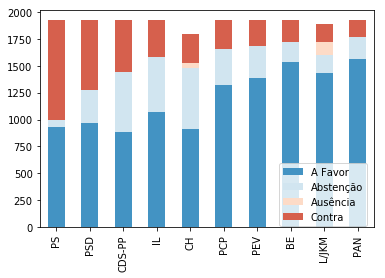

In [28]:
from matplotlib.colors import ListedColormap

votes_against = votes_hm.apply(pd.Series.value_counts).sort_values(by='Contra', ascending=False, axis=1).T
votes_against.plot(kind='bar', stacked=True, colormap=ListedColormap(sns.color_palette("RdBu_r", 4)),linewidth=0)
plt.legend(loc='center left', bbox_to_anchor=(0.7, 0.15))
plt.show()

## Matriz de distância entre os partidos

Com base nos histórico de votações de cada partido produzimos uma matriz de distâncias entre eles; uma matriz de distâncias é uma matriz quadradra $n\times n$ (onde _n_ é o número de partidos) e onde a distância entre _p_ e _q_ é o valor de $ d_{pq} $.

$ 
\begin{equation}
D= \begin{bmatrix} d_{11} & d_{12} & \cdots & d_{1 n} \\  d_{21} & d_{22} & \cdots & d_{2 n} \\ \vdots & \vdots & \ddots & \vdots \\ d_{31} & d_{32} & \cdots & d_{n n}   \end{bmatrix}_{\ n\times n}  
\end{equation}
$


A distância é obtida através da comparação de todas as observações de cada par usando uma determinada métrica de distância, sendo a distância euclideana bastante comum em termos gerais e também dentro de estudos sobre o mesmo domínio temático _(Krilavičius and Žilinskas 2008)_: cada elemento da matriz representa $ d\left( p,q\right)   = \sqrt {\sum _{i=1}^{n}  \left( q_{i}-p_{i}\right)^2 }$, equivalente, para dois pontos $P,Q $ , à mais genérica distância de Minkowski   $ D\left(P,Q\right)=\left(\sum _{i=1}^{n}|x_{i}-y_{i}|^{p}\right)^{\frac {1}{p}} $ para $ p = 1$, mas note-se que a diagonal da matrix irá representar a distância entre um partido e ele próprio, logo $ d_{11} = d_{22} = \dots = d_{nn} = 0 $.

Na secção  [Distâncias e matrizes](Distâncias_e_matrizes) colocámos uma discussão mais detalhada (mas passo-a-passo e destinada a quem não tenha necessariamente presente a matemática utilizada) sobre distâncias, _clustering_ e como são calculdadas, para quem tenha interesse numa compreensão mais quantitativa da matéria.

A conversão de votos em representações númericas pode ser feita de várias formas _(Hix, Noury, and Roland 2006)_; adoptamos a abordagem de Krilavičius & Žilinskas (2008) no já citado  trabalho relativo às votações no parlamento lituano por nos parecer apropriada à realidade portuguesa:

* A favor: 1
* Contra: -1
* Abstenção: 0
* Ausência: 0

Este ponto é (mais um) dos que de forma relativamente opaca - pois raramente os detalhes têm a mesma projecção que os resultado finais - podem influenciar os resultados; cremos que em particular a equiparação entre _abstenção_ e _ausência_ merece alguma reflexão: considerámos que uma ausência em determinada votação tem um peso equivalente à abstenção, embora uma de forma passiva e outra activa.

Para obtermos a matriz de distância usamos a função `pdist` e construímos um _dataframe_ que é uma matriz simétrica das distâncias entre os partidos.

In [29]:
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from itables import show

votes_hmn = votes_hm.replace(["A Favor", "Contra", "Abstenção", "Ausência"], [1,-1,0,0]).fillna(0)

## Transpose the dataframe used for the heatmap
votes_t = votes_hmn.transpose()

## Determine the Eucledian pairwise distance
## ("euclidean" is actually the default option)
pwdist = pdist(votes_t, metric='euclidean')

## Create a square dataframe with the pairwise distances: the distance matrix
distmat = pd.DataFrame(
    squareform(pwdist), # pass a symmetric distance matrix
    columns = votes_t.index,
    index = votes_t.index
)
#show(distmat, scrollY="200px", scrollCollapse=True, paging=False)

## Normalise by scaling between 0-1, using dataframe max value to keep the symmetry.
## This is essentially a cosmetic step to 
#distmat=((distmat-distmat.min().min())/(distmat.max().max()-distmat.min().min()))*1
distmat

,BE,PCP,PEV,L/JKM,PS,PAN,PSD,IL,CDS-PP,CH
BE,0.000000,25.159491,22.472205,19.974984,57.688820,30.626786,55.623736,46.173586,50.408333,43.726422
PCP,25.159491,0.000000,12.727922,27.892651,54.451814,37.349699,52.962251,46.465041,48.414874,42.930176
PEV,22.472205,12.727922,0.000000,25.845696,55.596762,35.425979,54.120237,46.529560,49.739320,43.554563
L/JKM,19.974984,27.892651,25.845696,0.000000,57.245087,30.545049,54.890801,45.088801,49.699095,42.930176
PS,57.688820,54.451814,55.596762,57.245087,0.000000,57.008771,38.755645,49.254441,44.933284,50.655701
PAN,30.626786,37.349699,35.425979,30.545049,57.008771,0.000000,51.555795,40.963398,46.765372,40.963398
PSD,55.623736,52.962251,54.120237,54.890801,38.755645,51.555795,0.000000,39.974992,31.543621,38.678159
IL,46.173586,46.465041,46.529560,45.088801,49.254441,40.963398,39.974992,0.000000,32.233523,33.136083
CDS-PP,50.408333,48.414874,49.739320,49.699095,44.933284,46.765372,31.543621,32.233523,0.000000,30.479501
CH,43.726422,42.930176,43.554563,42.930176,50.655701,40.963398,38.678159,33.136083,30.479501,0.000000


O mapa térmico é construído directamente a partir da matriz de distância, fornencendo uma forma bastante mais intuitiva de visualizar as distâncias:

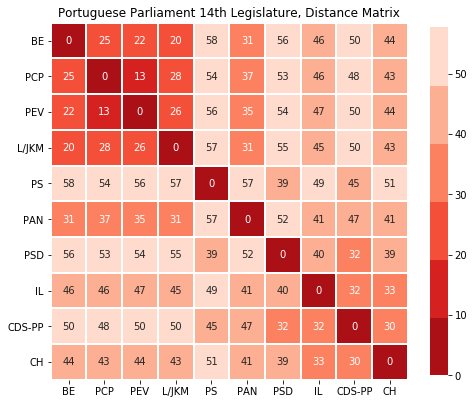

In [30]:
## Display the heatmap of the distance matrix

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()

sns.heatmap(
    distmat,
    cmap=sns.color_palette("Reds_r"),
    linewidth=1,
    annot = True,
    square =True,
    cbar_kws={"shrink": 0.8})
plt.title('Portuguese Parliament 14th Legislature, Distance Matrix')

plt.show()

A ordem dos índice é a que foi determinada anteriormente e baseada na localização dos partidos e deputados no hemiciclo; deixando considerações adicionais para depois note-se que duas das impressões iniciais obtidas pela observação do mapa térmico das votações) parecem confirmar-se:

1. O PAN parece de facto deslocado (restando saber para qual dos lados).
2. O quadrante superior esquerdo exibe distâncias menores que o inferior direito, demonstrando uma maior proximidade entre si dos partidos à esquerda do que à direita.

Com base nas distâncias procedemos ao agrupamento usando o método de Ward _(Carvalho et al. 2009)_  de forma a obtermos uma árvore de proximidade hierárquica: um dendograma, neste caso associado ao mapa térmica com as linhas e colunas devidamente reordenadas de forma a permitirem visualizar em simultâneo as distâncias e o agrupamentos (ver [Distâncias e matrizes](Distâncias_e_matrizes) para uma explicação mais aprofundanda do tema)

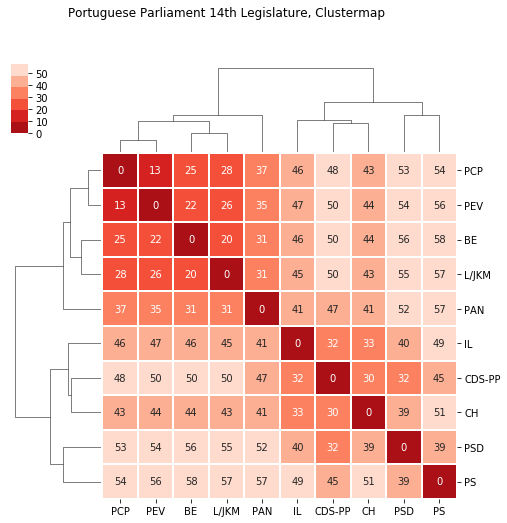

In [31]:
## Perform hierarchical linkage on the distance matrix using Ward's method.
distmat_link = hc.linkage(pwdist, method="ward", optimal_ordering=True )

sns.clustermap(
    distmat,
    annot = True,
    cmap=sns.color_palette("Reds_r"),
    linewidth=1,
    #standard_scale=1,
    row_linkage=distmat_link,
    col_linkage=distmat_link,
    figsize=(8,8)).fig.suptitle('Portuguese Parliament 14th Legislature, Clustermap')

plt.show()


Uma visualização apenas do dendograma é também possível; a altura das linhas e os pontos de derivação não são aleatórios, representam as distâncias determinadas pelo método de agrupamento:

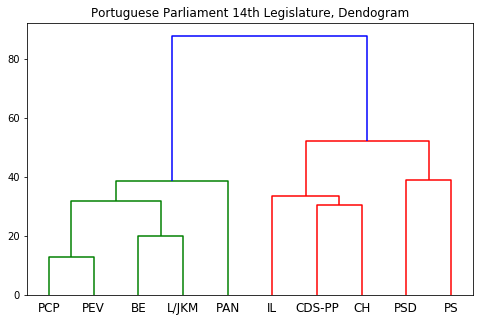

In [32]:
from scipy.cluster.hierarchy import dendrogram
fig = plt.figure(figsize=(8,5))
dendrogram(distmat_link, labels=votes_hmn.columns)

plt.title("Portuguese Parliament 14th Legislature, Dendogram")
plt.show()

## Identificar grupos e reduzir dimensões

Já conseguimos determinar as distâncias e os agrupamentos, mas as possibilidades de visualização não se esgotam por aí.

### _Clustering_ de observações: DBSCAN e _Spectrum Scaling_

Uma forma diferente de determinar agrupamentos é através de métodos de _clustering_, que procuram determinar agrupamentos de pontos com base em mecanismos específicos de cada um dos algoritmos.

Vamos demonstrar dois deles, e como passo preliminar vamos transformar a nossa matriz de distâncias: ao contrário do dendograma anterior estes métodos utilizam uma _matriz de afinidade_, onde valores mais altos significam uma maior semelhança (e, consequentemente, para uma matriz simétrica a diagonal passa de 0 para 1).

Como passo preliminar normalizamos as distâncias no intervalo $ [0,1] $:

In [33]:
import numpy as np

distmat_mm=((distmat-distmat.min().min())/(distmat.max().max()-distmat.min().min()))*1
pd.DataFrame(distmat_mm, distmat.index, distmat.columns)

,BE,PCP,PEV,L/JKM,PS,PAN,PSD,IL,CDS-PP,CH
BE,0.000000,0.436124,0.389542,0.346254,1.000000,0.530896,0.964203,0.800391,0.873797,0.757970
PCP,0.436124,0.000000,0.220631,0.483502,0.943888,0.647434,0.918068,0.805443,0.839242,0.744168
PEV,0.389542,0.220631,0.000000,0.448019,0.963735,0.614087,0.938141,0.806561,0.862200,0.754991
L/JKM,0.346254,0.483502,0.448019,0.000000,0.992308,0.529480,0.951498,0.781586,0.861503,0.744168
PS,1.000000,0.943888,0.963735,0.992308,0.000000,0.988212,0.671805,0.853795,0.778891,0.878085
PAN,0.530896,0.647434,0.614087,0.529480,0.988212,0.000000,0.893688,0.710075,0.810649,0.710075
PSD,0.964203,0.918068,0.938141,0.951498,0.671805,0.893688,0.000000,0.692942,0.546789,0.670462
IL,0.800391,0.805443,0.806561,0.781586,0.853795,0.710075,0.692942,0.000000,0.558748,0.574393
CDS-PP,0.873797,0.839242,0.862200,0.861503,0.778891,0.810649,0.546789,0.558748,0.000000,0.528343
CH,0.757970,0.744168,0.754991,0.744168,0.878085,0.710075,0.670462,0.574393,0.528343,0.000000


... e subtraimos à unidade todos os valores da matriz, uma forma simples de obter a matriz de afinidade (mas não a única, nem a que garantidamente resulta sempre melhor). O resultado é uma matriz cujos valores indicam a _semelhança_ entre os pares, ao invés da _distância_.

In [34]:
affinmat_mm = pd.DataFrame(1-distmat_mm, distmat.index, distmat.columns)
affinmat_mm 

,BE,PCP,PEV,L/JKM,PS,PAN,PSD,IL,CDS-PP,CH
BE,1.000000,0.563876,0.610458,0.653746,0.000000,0.469104,0.035797,0.199609,0.126203,0.242030
PCP,0.563876,1.000000,0.779369,0.516498,0.056112,0.352566,0.081932,0.194557,0.160758,0.255832
PEV,0.610458,0.779369,1.000000,0.551981,0.036265,0.385913,0.061859,0.193439,0.137800,0.245009
L/JKM,0.653746,0.516498,0.551981,1.000000,0.007692,0.470520,0.048502,0.218414,0.138497,0.255832
PS,0.000000,0.056112,0.036265,0.007692,1.000000,0.011788,0.328195,0.146205,0.221109,0.121915
PAN,0.469104,0.352566,0.385913,0.470520,0.011788,1.000000,0.106312,0.289925,0.189351,0.289925
PSD,0.035797,0.081932,0.061859,0.048502,0.328195,0.106312,1.000000,0.307058,0.453211,0.329538
IL,0.199609,0.194557,0.193439,0.218414,0.146205,0.289925,0.307058,1.000000,0.441252,0.425607
CDS-PP,0.126203,0.160758,0.137800,0.138497,0.221109,0.189351,0.453211,0.441252,1.000000,0.471657
CH,0.242030,0.255832,0.245009,0.255832,0.121915,0.289925,0.329538,0.425607,0.471657,1.000000


A matriz de afinididade pode agora ser visualizada de forma semelhante ao mapa térmico de distância:

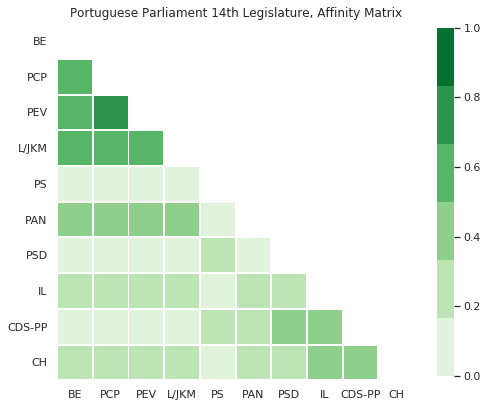

In [125]:
sns.set(style="white")

## Make the top triangle
mask = np.triu(np.ones_like(affinmat_mm, dtype=np.bool))
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()
plt.title('Portuguese Parliament 14th Legislature, Affinity Matrix')

## Display the heatmap of the affinity matrix, masking the top triangle

sns.heatmap(
    affinmat_mm,
    cmap=sns.color_palette("Greens"),
    linewidth=1,
    annot = False,
    square =True,
    cbar_kws={"shrink": .8},
    mask=mask,linewidths=.5)

plt.show()

Existem vários métodos de proceder à identificação de _clusters_; um deles é o DBSCAN (_Density-Based Spatial Clustering of Applications with Noise_), um algoritmo que, entre outras características, não necessita de ser inicializado com um número pré-determinado de grupos, procedendo à sua identificação através da densidade dos pontos _(“DBSCAN: Macroscopic Investigation Python” 2018)_.

Note-se que estes métodos são normalmente utilizados com um maior número de observações,; seria, por exemplo, um método que através do registo dos votos individuais de cada deputado identificaria os partidos. Aqui temos um número reduzido de observações (pois estamos a utilizar uma matriz de semelhança entre $10\times10$, o que também explica o reduzido número de _clusters_ identificados - dois, alinhados com a primeira divisão já identificada no dendograma:

In [36]:
from sklearn.cluster import DBSCAN

dbscan_labels = DBSCAN(eps=1.1).fit(affinmat_mm)
dbscan_labels.labels_
dbscan_dict = dict(zip(distmat_mm,dbscan_labels.labels_))
dbscan_dict

{'BE': 0,
 'PCP': 0,
 'PEV': 0,
 'L/JKM': 0,
 'PS': 1,
 'PAN': 0,
 'PSD': 1,
 'IL': 1,
 'CDS-PP': 1,
 'CH': 1}

Outra abordagem para efectuar a identificação de grupos  passa pela utilização de _Spectral Clustering_, uma forma de _clustering_ que utiliza os valores-próprios e vectores-próprios de matrizes como forma de determinação dos grupos. Este método necessita que seja determinado _a priori_ o número de _clusters_; com base na análise anterior (dendograma) observámos que temos 4 grupos constituidos por 2 partidos, e nesse sentido usar 4 permite-nos aferir se a distribuição dos restantes está alinhada com a separação proposta pelo modelo anterior.

In [37]:
from sklearn.cluster import SpectralClustering
sc = SpectralClustering(4, affinity="precomputed",random_state=2020).fit_predict(affinmat_mm)
sc_dict = dict(zip(distmat,sc))

print(sc_dict)

{'BE': 3, 'PCP': 1, 'PEV': 1, 'L/JKM': 3, 'PS': 0, 'PAN': 3, 'PSD': 0, 'IL': 2, 'CDS-PP': 2, 'CH': 2}


O agrupamento está em linha com o que observámos no dendograma - mas tal não era garantido ou necessário pois diferentes formas de agregação podem ter resultados diferentes que devem ser fonte de análise e podem fornecer dados adicionais interessantes. A utilização de _Spectrum Scaling_ permite-nos aqui determinar um número de grupos maior.

### _Multidimensional scaling_ 

Até agora temos conseguido extrair informação interessante dos dados de votação:

1. O mapa térmico de votação permite-nos uma primeira visão do comportamente de todos os partidos. 
2. A matriz de distâncias fornece-nos uma forma de comparar as distâncias entre os diferentes partidos através de um mapa térmico.
3. O dendograma identifica de forma hierárquica agrupamentos.
4. Através de DBSCAN e _Spectrum Clustering_ identificamos "blocos" com base na matriz de afinidade.

Não temos ainda uma forma de visualizar a distância relativa de cada partido em relação aos outros com base nas distâncias/semelhanças: temos algo próximo com base no dendograma mas existem outras formas de visualização interessantes.

Uma das formas é o _multidimensional scaling_ que permite visualizar a distância ao projectar em 2 ou 3 dimensões (também conhecidas como _dimensões visualizavies_) conjuntos multidimensionais, mantendo a distância relativa _(“Graphical Representation of Proximity Measures for Multidimensional Data « The Mathematica Journal” 2020)_.

Como é habitual temos em Python, através da biblioteca `scikit-learn` (que já usámos para DBSCAN e _Spectrum Clustering_), uma implementação que podemos usar sem grande dificuldade _(“2.2. Manifold Learning — Scikit-Learn 0.23.2 Documentation” 2020)_.

In [38]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, dissimilarity='precomputed',random_state=2020, n_init=100, max_iter=1000)

## We use the normalised distance matrix but results would
## be similar with the original one, just with a different scale/axis
results = mds.fit(distmat_mm.values)
coords = results.embedding_
coords

array([[ 0.32539045,  0.34692697],
       [ 0.00679681,  0.41709524],
       [ 0.11196357,  0.43337417],
       [ 0.40928771,  0.21169564],
       [-0.68744264,  0.15127295],
       [ 0.48062855, -0.0954891 ],
       [-0.52037057, -0.29304291],
       [ 0.14716176, -0.48079997],
       [-0.21350142, -0.47479578],
       [-0.05991423, -0.21623722]])

O resultado é um um conjunto de pontos definidos por coordenadas, neste caso 2 ($x,y$) dado termos especificado que queriamos reduzir para `n_components = 2`. Com estas coordenadas podemos facilmente criar um gráfico de dispersão:

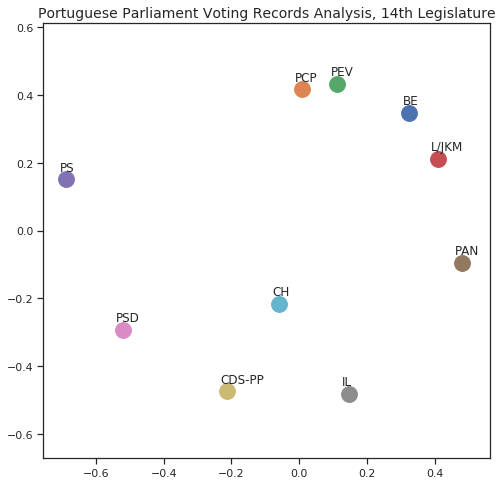

In [39]:
## Graphic options
sns.set()
sns.set_style("ticks")

fig, ax = plt.subplots(figsize=(8,8))

plt.title('Portuguese Parliament Voting Records Analysis, 14th Legislature', fontsize=14)

for label, x, y in zip(distmat_mm.columns, coords[:, 0], coords[:, 1]):
    ax.scatter(x, y, s=250)
    ax.axis('equal')
    ax.annotate(label,xy = (x-0.02, y+0.025))
plt.show()

Através de MDS podemos agora ter uma ideia mais clara do que, visualmente, representam as distâncias que calculámos, reduzidas para duas dimensões. Isto dá-nos a possibilidade de definirmos agrupamentos da forma que consideremos mais adequada.

Em todo o caso, e visto que temos os resultados de DBSCAN e de  _Spectrum Clustering_, podemos adicionar também esta informação, complementando o MDS com a informação anterior ao definirmos as cores dos marcadores de cada partido consoante o grupo previamente identificado.

Para o caso de DBSCAN:

<IPython.core.display.Javascript object>


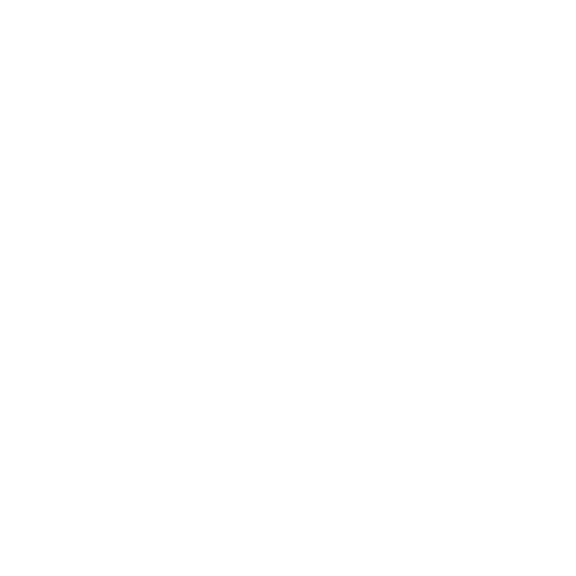

<IPython.core.display.Javascript object>


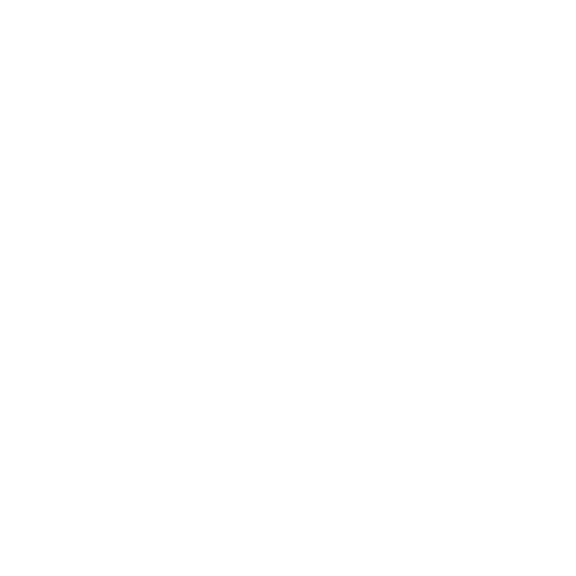

In [99]:
from sklearn.manifold import MDS
import random

sns.set()
sns.set_style("ticks")


fig, ax = plt.subplots(figsize=(8,8))

fig.suptitle('Portuguese Parliament Voting Records Analysis, 14th Legislature', fontsize=14)
ax.set_title('MDS with DBSCAN clusters (2D)')

for label, x, y in zip(distmat_mm.columns, coords[:, 0], coords[:, 1]):
    ax.scatter(x, y, c = "C"+str(dbscan_dict[label]), s=250)
    ax.axis('equal')
    ax.annotate(label,xy = (x-0.02, y+0.025))

plt.show()

e para _Spectrum Clustering_, com um maior número de _clusters_:

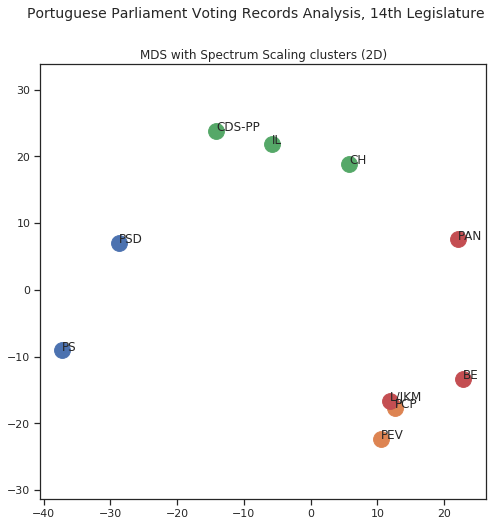

In [103]:
from sklearn.manifold import MDS
import random

sns.set()
sns.set_style("ticks")

fig, ax = plt.subplots(figsize=(8,8))
fig.suptitle('Portuguese Parliament Voting Records Analysis, 14th Legislature', fontsize=14)
ax.set_title('MDS with Spectrum Scaling clusters (2D)')


for label, x, y in zip(distmat_mm.columns, coords[:, 0], coords[:, 1]):
    ax.scatter(x, y, c = "C"+str(sc_dict[label]), s=250)
    ax.axis('equal')
    ax.annotate(label,xy = (x-0.02, y+0.025))

plt.show()

É interessante reparar que ambos os métodos apresentam resultados compatíveis (os resultados de _Spectrum Clustering_ são essencialmente uma divisão dentro dos grupos identificados por DBSCAN) e ambos fazem visualmente sentido quando consideradas as distâncias do diagrama de MDS.

### MDS em 3 dimensões: hiperplanos ideológicos

Usámos MDS a duas dimensões, mas podemos fazê-lo também a 3 dimensões. Esta visualização será, provavelmente, a que mais interesse despertará: não por ser qualitativamente melhor que a anterior (adiciona de facto mais uma dimensão mas é discutível que seja mais compreensível), mas porque quem queira usar os dados apresentados até agora para justificar as suas próprias posições está de certa forma constrangido pela forma directa como as tabelas e os gráficos são exibidos: é sempre possível (e desejável) tecer considerações várias sobre o que foi apresentado mas essas considerações estão limitadas pela bidimensionalidade dos diagramas.

Tal não acontece com a visualização do MDS em 3D: na forma interactiva que apresentamos permite a manipulação (nos vários sentidos da palavra) do cubo de forma a construir seja qual for o "compasso", "quadrante" ou esquema similar que seja desejado: ajustando os vários eixos há sempre forma de se poder "provar" que determinado partido está "no extremo" ou que outro "está próximo", que um é "do centro" e os outros "marginais": tal como estrelas numa constelação pode-se construir artificialmente uma visão a duas dimensões que não reflecte a verdadeira distância.

Nesta espécie de pacote "faça o seu próprio compasso político" cada um passa a poder escolher o hiperplano ideológico que mais lhe convém, com a vantagem de poder ser apresentado como "baseado em dados e análises quantitativas" (mesmo que, ao omitir a terceira dimensão, esteja de facto a representar a informação _pior_ do que a versão a duas dimensões).

Dito isto, a versão interactiva (e até certas visualização fixas de certos ângulos que permitem uma maior noção da terceira dimensão) é útil pois permite uma maior interactividade e adiciona mais uma dimensão, logo potencialmente mais informação.

Para podernos anotar o gráfico definimos algums funções auxiliares _(“Python - Matplotlib: Annotating a 3D Scatter Plot - Stack Overflow” 2020)_

In [42]:
## From https://stackoverflow.com/questions/10374930/matplotlib-annotating-a-3d-scatter-plot

from mpl_toolkits.mplot3d.proj3d import proj_transform
from matplotlib.text import Annotation

class Annotation3D(Annotation):
    '''Annotate the point xyz with text s'''

    def __init__(self, s, xyz, *args, **kwargs):
        Annotation.__init__(self,s, xy=(0,0), *args, **kwargs)
        self._verts3d = xyz        

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.xy=(xs,ys)
        Annotation.draw(self, renderer)
        
def annotate3D(ax, s, *args, **kwargs):
    '''add anotation text s to to Axes3d ax'''

    tag = Annotation3D(s, *args, **kwargs)
    ax.add_artist(tag)

O processo é semelhante aos anteriores, com a definição de 3 dimensões via o parâmetro `n_components` e alguns ajustes na contrução do gráfico:

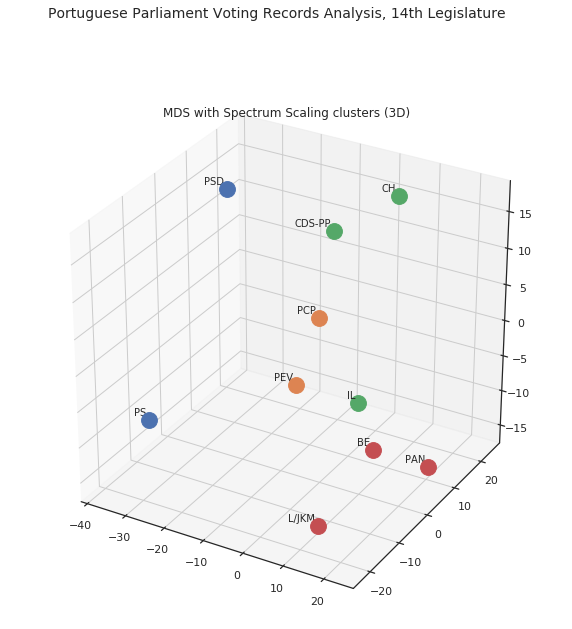

In [106]:
%matplotlib inline
from sklearn.manifold import MDS
#from mpl_toolkits.mplot3d import Axes3
import mpl_toolkits.mplot3d
import random

mds = MDS(n_components=3, dissimilarity='precomputed',random_state=1234, n_init=100, max_iter=1000)
results = mds.fit(distmat.values)
parties = distmat.columns
coords = results.embedding_

sns.set()
sns.set_style("ticks")

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

fig.suptitle('Portuguese Parliament Voting Records Analysis, 14th Legislature', fontsize=14)
ax.set_title('MDS with Spectrum Scaling clusters (3D)')

for label, x, y, z in zip(parties, coords[:, 0], coords[:, 1], coords[:, 2]):
    #print(label,pmds_colors[label])
    ax.scatter(x, y, z, c="C"+str(sc_dict[label]),s=250)
    annotate3D(ax, s=str(label), xyz=[x,y,z], fontsize=10, xytext=(-3,3),
               textcoords='offset points', ha='right',va='bottom')  
plt.show()


## Conclusão


Existe uma proliferação de recursos e questionários assentes em "quadrantes", "compassos" e outros termos que pretendem posicionar o utilizador em termos ideológicos, com metodologias diferentes (e com resultados diferentes) e de diversos graus de complexidade e sofisticação _(Wall, Krouwel, and Kleinnijenhuis 2012)_. Este trabalho não pretende ser uma "revelação" ou emprestar uma base "científica" aos posicionamentos de cada um através de uma "matematização" do conhecimento enquanto valorizador qualitativo, lembrando Ortega y Gasset e a forma crítica como referia a tendência de todas disciplinas se quererem ao exemplo da física _(Ortega y Gasset 1995)_.

Nesta conclusão iremos consciente e explicitamente abandonar pretensões de completa neutralidade e distanciamento, sem que isso signifique a execução de um determinado programa político pessoal: trata-se tão só do resultado natural da análise dos dados sob um prisma mais qualitativo.

Os resultados obtidos são, de certa forma, razoavelmente modestos em termos de novidades:

* Existe uma primeira divisão entre os partidos que se enquadra nos conceitos de Esquerda e Direita.
* Nesta divisão o posicionamento do Partido Socialista será, talvez, um dos pontos mais sensíveis.
* O PAN aparece agrupado à esquerda (não obstante ser o primeiro a ser diferenciado dos restantes).
* Á direita o agrupamento entre CDP-PP, IL e CHEGA é bastante próximo, sendo que o método de agrupamento utilizado diferencia a IL primeiro que os restantes (mas outros métodos têm, empiricamente falando, outros resultados).
* Á esquerda a CDU (PCP/PEV) e o BE+Livre/JKM são diferenciados.

Há que ter em conta o facto do Partido Socialista ser o partido de sustentação do Governo, algo que determina de várias formas a forma como as votações ocorrem; de que forma é que este facto influencia o seu posicionamento não é posível quantificar mas intutitivamente não será irrelevante.

**À direita**, e pondo de lado a já referida inclusão do PS que pode ter as razões apontadas como factor relevante, o PSD aparece com um posicionamento pouco surpreendente no sentido em que se enquadra no "centro-direita" que se esperaria, sem prejuízo do posicionamento mais amplo que em diferentes fases possa considerar adequadas _(Lourinho 2020)_.

A distância entre CDS-PP, CHEGA e IL é bastante pequena (note-se que embora os partidos à esquerda sejam genericamente mais próximos exibem distâncias entre si _maiores_ do que estes três); este resultado será talvez mais interessante para a IL no sentido em ser, como referido anteriormente, quem mais frequentemente recusa ser classificado em termos de "esquerda e direita" _(“Iniciativa Liberal Descontente Com Lugar Atribuído a Deputado No Parlamento - TSF” 2020)_: em termos de votações esta pretensão não tem aparente materialização quantitativa, sempre dentro dos contragimentos explicitamente identificados.

**Á esquerda**, o resultado não nos parece ser grandemente surpreendente: apesar das diferenças em várias votações o PCP e o PEV (este mais próximo dos restantes partidos agrupados à esquerda) aparecem como um bloco diferenciável do BE e Livre/JKM. No caso  do PCP e PEV a proximidade não é estranha considerando serem partidos pertencentes a uma mesma coligação eleitoral _(Lusa 2020b)_, mas também no caso do BE e Livre/JKM há que considerar a proximidade histórica existente _(ZAP 2019)_.

A posição do PAN será, aqui, provavelmente a mais interessamente no sentido em que este se classifica como "nem de esquerda ou direita" _(“Expresso | A História Do Partido Que Diz Que Não É de Direita Nem de Esquerda: O PAN” 2020)_: aparece "à esquerda" (estamos sempre aqui a mapear os resultados com uma realidade pre-existente) do Partido Socialista, e embora sendo por pouco não deixa de ser relevante.

Outras leituras podem ser feitas (e dadas as várias dimensões dos dados, leituras aparentemente opostas podem coexistir) tanto com os resultados apresentados como através da alterção da forma de tratamento dos dados.

Em termos de _Data Science_, este trabalho poderia (e poderá) ter uma continuidade, nomeadamente dentro do que são as possibilidade do _Watson Studio_, componente da plataforma "IBM Cloud Pak for Data" _(“IBM Cloud Pak for Data” 2020)_: execução diária da extração de dados, validação dos mesmos, actualização dos resultados de forma automática e também a possibilidade de criação de modelos preditivos automaticamente actualizados e testados através de _Watson Machine Learning_ _(“Watson Machine Learning - Overview | IBM” 2020)_; estas possibilidades da plataforma IBM Watson são transversais a qualquer projecto de _Data Science_, sendo o presente trabalho apenas um exemplo que utiliza uma pequena parte das funcionalidades disponibilizadas.

Para finalizar, e considerando sempre a necessidade de analise crítica dos dados apresentados e a sua correcção, recordamos quando um (excelente) professor (de uma matéria bastante relevante para a análise efectuada) utilizou, numa das suas aulas, uma citação que se mantém fundamental: _"Se não temo o erro, é porque estou sempre disposto a corrigi-lo"_ <cite data-cite="1084038/278R348A"></cite>. Também para este trabalho estamos necessariamente abertos a correcções e sugestões fundamentadas.

## Bibliografia

* “2.2. Manifold Learning — Scikit-Learn 0.23.2 Documentation.” 2020. Accessed September 2. https://scikit-learn.org/stable/modules/manifold.html#multidimensional-scaling.
* Almeida, Joana. 2019. “CDS explica contestação ao lugar do Chega no Parlamento: ‘André Ventura pode cansar-se e dizer “olhe, basta, chega.”’” O Jornal Económico. October 23. https://jornaleconomico.sapo.pt/noticias/cds-explica-contestacao-ao-lugar-do-chega-no-parlamento-andre-ventura-pode-cansar-se-e-dizer-olhe-basta-chega-504766.
* Carvalho, Alexandre Xavier Ywata, Pedro Henrique Melo Albuquerque, Gilberto Rezende de Almeida Junior, and Rafael Dantas Guimaraes. 2009. “Spatial Hierarchical Clustering.” Revista Brasileira de Biometria 27 (3): 411–42.
* “Cleaning Big Data: Most Time-Consuming, Least Enjoyable Data Science Task, Survey Says.” 2020. Accessed August 20. https://www.forbes.com/sites/gilpress/2016/03/23/data-preparation-most-time-consuming-least-enjoyable-data-science-task-survey-says/#8e17b266f637.
* “Dados Abertos.” 2020. Accessed August 17. https://www.parlamento.pt/Cidadania/Paginas/DadosAbertos.aspx.
* “DBSCAN: Macroscopic Investigation Python.” 2018. DataCamp Community. August 3. https://www.datacamp.com/community/tutorials/dbscan-macroscopic-investigation-python.
* Dodds, Leigh. 2020. “Do Data Scientists Spend 80% of Their Time Cleaning Data? Turns Out, No?” Lost Boy. January 31. https://blog.ldodds.com/2020/01/31/do-data-scientists-spend-80-of-their-time-cleaning-data-turns-out-no/.
* “Estão Distribuídas (para Já) as Cadeiras No Parlamento - DN.” 2020. Accessed August 25. https://www.dn.pt/poder/nova-legislatura-estao-distribuidas-para-ja-as-cadeiras-no-parlamento-11412255.html.
* “Expresso | A História Do Partido Que Diz Que Não É de Direita Nem de Esquerda: O PAN.” 2020. Accessed September 20. https://expresso.pt/europeias-2019/2019-05-27-A-historia-do-partido-que-diz-que-nao-e-de-direita-nem-de-esquerda-o-PAN.
* Figueiredo Filho, Dalson Britto, Enivaldo Carvalho da Rocha, José Alexandre da Silva Júnior, Ranulfo Paranhos, Mariana Batista da Silva, and Bárbara Sofia Félix Duarte. 2014. “Cluster Analysis for Political Scientists.” Applied Mathematics 2014.
* “Frase do matemático português Bento de Jesus Caraça.” 2020. Sociedade Portuguesa de Matemática. Accessed September 20. https://www.spm.pt/news/4730.
* “Graphical Representation of Proximity Measures for Multidimensional Data « The Mathematica Journal.” 2020. Accessed September 2. https://www.mathematica-journal.com/2015/09/30/graphical-representation-of-proximity-measures-for-multidimensional-data/.
* Hix, Simon, Abdul Noury, and Gérard Roland. 2006. “Dimensions of Politics in the European Parliament.” American Journal of Political Science 50 (2): 494–511. https://www.jstor.org/stable/3694286.
* “IBM Cloud Pak for Data.” 2020. Accessed September 20. https://dataplatform.cloud.ibm.com/home2?context=cpdaas.
* “Iniciativa Liberal Descontente Com Lugar Atribuído a Deputado No Parlamento - TSF.” 2020. Accessed August 17. https://www.tsf.pt/portugal/politica/iniciativa-liberal-descontente-com-lugar-atribuido-a-deputado-no-parlamento-11412664.html.
* Jackson, Robert J. 1968. Rebels and Whips: An Analysis of Dissension, Discipline and Cohesion in British Political Parties. Macmillan.
* Krilavičius, Tomas, and Antanas Žilinskas. 2008. “On Structural Analysis of Parliamentarian Voting Data.” Informatica 19 (3): 377–90.
* Lourenço, Eunice. 2020. “Guerra de lugares.” PÚBLICO. Accessed August 17. https://www.publico.pt/1999/10/26/jornal/guerra-de-lugares-125525.
* Lourinho, José Carlos. 2020. “Rui Rio: ‘Tanto sou do centro-direita como do centro-esquerda.’” O Jornal Económico. January 14. https://jornaleconomico.sapo.pt/noticias/rui-rio-tanto-sou-do-centro-direita-como-do-centro-esquerda-535068.
* Lusa. 2020a. “Quadro de tempos e votações da AR já distingue as duas deputadas não-inscritas.” PÚBLICO. Accessed August 23. https://www.publico.pt/2020/06/26/politica/noticia/quadro-tempos-votacoes-ar-ja-distingue-duas-deputadas-naoinscritas-1922017.
* ———. 2020b. “PCP e PEV confirmam convergência e priorizam creches, salários, ambiente e ferrovia.” PÚBLICO. Accessed September 20. https://www.publico.pt/2019/10/24/politica/noticia/pcp-pev-confirmam-convergencia-priorizam-creches-salarios-ambiente-ferrovia-1891225.
* “‘N’-Dimensional Euclidean Distance.” 2020. Accessed September 5. https://hlab.stanford.edu/brian/euclidean_distance_in.html.
* Ortega y Gasset, José. 1995. ¿ Qué Es Filosofía?. Espasa Calpe.
* Powers, Stephen M., and Stephanie E. Hampton. 2019. “Open Science, Reproducibility, and Transparency in Ecology.” Ecological Applications 29 (1): e01822.
* “Python - Matplotlib: Annotating a 3D Scatter Plot - Stack Overflow.” 2020. Accessed September 4. https://stackoverflow.com/questions/10374930/matplotlib-annotating-a-3d-scatter-plot.
* Randles, Bernadette M., Irene V. Pasquetto, Milena S. Golshan, and Christine L. Borgman. 2017. “Using the Jupyter Notebook as a Tool for Open Science: An Empirical Study.” In 2017 ACM/IEEE Joint Conference on Digital Libraries (JCDL), 1–2. IEEE.
* Renascença. 2019. “Uma nova porta para o Chega? Perceba porque é tão difícil sentar os deputados - Renascença.” Rádio Renascença. October 22. https://rr.sapo.pt/2019/10/22/legislativas-2019/uma-nova-porta-para-o-chega-perceba-porque-e-tao-dificil-sentar-os-deputados/noticia/169040/.
* Sapage, Sónia. 2020. “‘Hemiciclo.pt’ é uma nova versão digital do Parlamento.” PÚBLICO. Accessed September 21. https://www.publico.pt/2017/09/04/politica/noticia/hemiciclo-uma-nova-versao-digital-do-parlamento-1784304.
* “Spectral Clustering. Foundation and Application | by William Fleshman | Towards Data Science.” 2020. Accessed September 1. https://towardsdatascience.com/spectral-clustering-aba2640c0d5b.
* “Votação dos cinco projetos da eutanásia será nominal - JN.” 2020. Accessed August 20. https://www.jn.pt/nacional/votacao-dos-cinco-projetos-da-eutanasia-sera-nominal--11838428.html.
* Wall, Matthew, André Krouwel, and Jan Kleinnijenhuis. 2012. “Political Matchmakers: How Do the Decision Rules Employed by Vote Advice Application Sites Influence Their Advice?” In Elecdem Conference, Florence, 28–30.
* “Watson Machine Learning - Overview | IBM.” 2020. Accessed September 20. https://www.ibm.com/cloud/machine-learning.
* Wofford, Morgan F., Bernadette M. Boscoe, Christine L. Borgman, Irene V. Pasquetto, and Milena S. Golshan. 2019. “Jupyter Notebooks as Discovery Mechanisms for Open Science: Citation Practices in the Astronomy Community.” Computing in Science & Engineering 22 (1): 5–15.
* ZAP. 2019. “O Livre procurou o Bloco. E é mais o que os une do que o que os separa.” ZAP. October 24. https://zap.aeiou.pt/livre-procurou-bloco-287820.

----
## Apêndice

### Iniciativas e votações

Há uma **diferença entre a primeira votação e a primeira iniciativa** (e, em termos gerais, entre iniciativas e votações): existem iniciativas que por razões várias não têm votações associadas. Assim, note-se os detalhes da primeira iniciativa e como o tema é diferente do apresentados para a primeira iniciativa com votação mostrada anteriormente:

In [44]:
for c in ini_tree.find("pt_gov_ar_objectos_iniciativas_DetalhePesquisaIniciativasOut"):
        print("{0:15}: {1}".format(c.tag,c.text))

iniNr          : 28
iniTipo        : A
iniDescTipo    : Apreciação Parlamentar
iniLeg         : XIV
iniSel         : 1
dataInicioleg  : 2019-10-25
dataFimleg     : 2020-09-14
iniTitulo      : Decreto-Lei n.º 29/2020, de 29 de junho, que "Cria um programa de apoio ao emparcelamento rural simples, designado «Emparcelar para Ordenar»"
iniTextoSubst  : NAO
iniLinkTexto   : http://app.parlamento.pt/webutils/docs/doc.pdf?path=6148523063446f764c324679595842774f6a63334e7a637664326c756157357059326c6864476c3259584d7657456c574c33526c6548527663793977595841794f433159535659755a47396a&fich=pap28-XIV.doc&Inline=true
iniEventos     : None
iniAutorDeputados: None
iniAutorOutros : None
iniId          : 45156
iniAutorGruposParlamentares: None


Esta iniciativa não tem votações associadas pelo que não irá ser incluída na tabela que lista as votações, mas deveria ser incluída numa tabela com objectivos diferentes do presente trabalho, focada por exemplo nas iniciativas parlamentares; aproveitemo-la, porém, para demonstrar como extrair a informação da autoria da iniciativa: os campos onde aparece `None`são quase sempre campos que contém informação com vários níveis e que é preciso extrair de forma especial. Para a autoria existe a secção `iniAutorGruposParlamentares` que contém um objecto `pt_gov_ar_objectos_AutoresGruposParlamentaresOut` com o nome do grupo parlamentar como conteúdo de `GP`:

In [45]:
for c in ini_tree.find("pt_gov_ar_objectos_iniciativas_DetalhePesquisaIniciativasOut"):
    if c.tag == "iniAutorGruposParlamentares":
        print("{0:30}: {1}".format(c.tag,c.find('pt_gov_ar_objectos_AutoresGruposParlamentaresOut/GP').text))
    else:
        print("{0:30}: {1}".format(c.tag,c.text))

iniNr                         : 28
iniTipo                       : A
iniDescTipo                   : Apreciação Parlamentar
iniLeg                        : XIV
iniSel                        : 1
dataInicioleg                 : 2019-10-25
dataFimleg                    : 2020-09-14
iniTitulo                     : Decreto-Lei n.º 29/2020, de 29 de junho, que "Cria um programa de apoio ao emparcelamento rural simples, designado «Emparcelar para Ordenar»"
iniTextoSubst                 : NAO
iniLinkTexto                  : http://app.parlamento.pt/webutils/docs/doc.pdf?path=6148523063446f764c324679595842774f6a63334e7a637664326c756157357059326c6864476c3259584d7657456c574c33526c6548527663793977595841794f433159535659755a47396a&fich=pap28-XIV.doc&Inline=true
iniEventos                    : None
iniAutorDeputados             : None
iniAutorOutros                : None
iniId                         : 45156
iniAutorGruposParlamentares   : PCP


A **autoria das iniciativas** onde se integram as votações pode ser registada, mas é importante ter claro que esta autoria **é independente da autoria da matéria em votação**: uma iniciativa de um partido pode integrar votações propostas por outros. Esta situação não impacta a possiblidade de análise a que nos propomos mas abre áreas de exploração adicional para o futuro. Tendo em conta o objectivo deste trabalho optou-se por utilizar apenas a informação das votações de forma a tornar o código mais simples e focado, deixando para um segundo trabalho (em curso) uma contextualização mais ampla.

### Processamento da descrição de votos

**Começemos pela primeira** usando a votação `86004` que representa o primeira caso ao ser uma votação nominal, uma das cinco relativas aos projectos relativos à eutanásia <cite data-cite="1084038/C56FTGBX"></cite>:

In [46]:
from bs4 import BeautifulSoup

def parse_voting1(v_str):
    """Parses the voting details in a string and returns a dict.
    
    Keyword arguments:
    
    v_str: a string with the description of the voting behaviour.
    """
    ## Split by the HTML line break and put it in a dict
    d = dict(x.split(':') for x in v_str.split('<BR>'))
    ## Remove the HTML tags
    for k, v in d.items():
        ctext = BeautifulSoup(v, "lxml")
        d[k] = ctext.get_text().strip().split(",")
    ## Invert the dict to get a 1-to-1 mapping
    ## and trim it
    votes = {}
    for k, v in d.items():
        for p in v:
            ## Sometimes there are empty entries ("boo, , bar, baz"), bypass them
            if p != ' ':
                votes[p.strip()] = k
    return votes

for v in ini_tree.find(".//pt_gov_ar_objectos_VotacaoOut/[id='86004']"):
    if v.tag == "detalhe":
        vote_86004 = parse_voting1(v.text)
        print("\t{0:15}: {1}".format(v.tag,parse_voting1(v.text)))
    else:
        print("\t{0:15}: {1}".format(v.tag,v.text))

	id             : 86004
	resultado      : Aprovado
	reuniao        : 32
	tipoReuniao    : RP
	detalhe        : {'Bruno Aragão (PS)': 'A Favor', 'Ana Maria Silva (PS)': 'A Favor', 'Joana Bento (PS)': 'A Favor', 'João Gouveia (PS)': 'A Favor', 'Ana Passos (PS)': 'A Favor', 'Francisco Pereira Oliveira (PS)': 'A Favor', 'Sara Velez (PS)': 'A Favor', 'Rita Borges Madeira (PS)': 'A Favor', 'Diogo Leão (PS)': 'A Favor', 'João Miguel Nicolau (PS)': 'A Favor', 'Alexandra Tavares de Moura (PS)': 'A Favor', 'Fernando Anastácio (PS)': 'A Favor', 'Fernando Paulo Ferreira (PS)': 'A Favor', 'Vera Braz (PS)': 'A Favor', 'Paulo Marques (PS)': 'A Favor', 'Eduardo Barroco de Melo (PS)': 'A Favor', 'Manuel dos Santos Afonso (PS)': 'A Favor', 'Mara Coelho (PS)': 'A Favor', 'Sofia Araújo (PS)': 'A Favor', 'Fernando José (PS)': 'A Favor', 'Clarisse Campos (PS)': 'A Favor', 'Cláudia Santos (PS)': 'A Favor', 'Filipe Neto Brandão (PS)': 'A Favor', 'Porfírio Silva (PS)': 'A Favor', 'Susana Correia (PS)': 'A Favo

A divisão dos votos por partido para esta votação em específico é a seguinte para esta votação:

In [47]:
import pandas as pd
import re
## Initialise an empty dict
vote_e = {}

## Iteract through the existing dict with the nominal voting results
for k, v in vote_86004.items():
    print(k,v)
    ## Erase the name of the MP and keep the party only
    nk = re.sub(r".*\((.+?)\).*", r"\1", k)
    ## If it's the first entry for a key, create it
    if nk not in vote_e:
        vote_e[nk] = [0,0,0]
    ## Add to a specific index in a list
    if v == "A Favor":
        vote_e[nk][0] += 1
    elif v == "Abstenção":
        vote_e[nk][1] += 1
    elif v == "Contra":
        vote_e[nk][2] += 1

## Convert dict to pandas dataframe, add a total columns and display it
vote_e_df = pd.DataFrame.from_dict(vote_e, orient='index', columns=['A Favor', 'Abstenção', 'Contra'])
vote_e_df['Total'] = vote_e_df.sum(axis=1)
vote_e_df

Bruno Aragão (PS) A Favor
Ana Maria Silva (PS) A Favor
Joana Bento (PS) A Favor
João Gouveia (PS) A Favor
Ana Passos (PS) A Favor
Francisco Pereira Oliveira (PS) A Favor
Sara Velez (PS) A Favor
Rita Borges Madeira (PS) A Favor
Diogo Leão (PS) A Favor
João Miguel Nicolau (PS) A Favor
Alexandra Tavares de Moura (PS) A Favor
Fernando Anastácio (PS) A Favor
Fernando Paulo Ferreira (PS) A Favor
Vera Braz (PS) A Favor
Paulo Marques (PS) A Favor
Eduardo Barroco de Melo (PS) A Favor
Manuel dos Santos Afonso (PS) A Favor
Mara Coelho (PS) A Favor
Sofia Araújo (PS) A Favor
Fernando José (PS) A Favor
Clarisse Campos (PS) A Favor
Cláudia Santos (PS) A Favor
Filipe Neto Brandão (PS) A Favor
Porfírio Silva (PS) A Favor
Susana Correia (PS) A Favor
Hugo Oliveira (PS) A Favor
Joana Sá Pereira (PS) A Favor
Telma Guerreiro (PS) A Favor
Sónia Fertuzinhos (PS) A Favor
Maria Begonha (PS) A Favor
Hugo Pires (PS) A Favor
Palmira Maciel (PS) A Favor
Luís Soares (PS) A Favor
Nuno Sá (PS) A Favor
Pedro Coimbra (P

,A Favor,Abstenção,Contra,Total
PS,79,18,9,106
PSD,10,4,59,73
BE,19,0,0,19
PAN,4,0,0,4
Ninsc,1,0,0,1
IL,1,0,0,1
PCP,0,0,10,10
CDS-PP,0,0,5,5
CH,0,0,1,1
PEV,0,2,0,2


Um gráfico de barras torna claro que a divisão ocorreu apenas nos dois maiores grupos parlamentares.

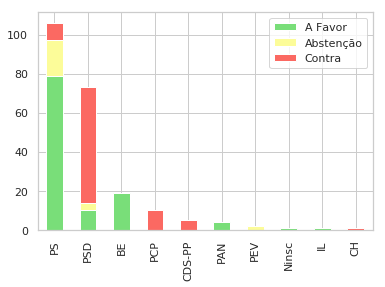

In [97]:
%matplotlib inline

## Plot a stacked bar plot using the dataframe
import seaborn as sns

legend_colors = ["#79DE79", "#FCFC99","#FB6962"]
sns.set(style="whitegrid")

## Plot sorted by total number of votes
vote_e_df.sort_values('Total', ascending=False).drop('Total',axis=1).plot(kind="bar", stacked=True, color=sns.color_palette(legend_colors))

O segundo caso diz respeito a **votações onde a posição partidária é indicada e apenas as excepções incluídas**; nestes casos existem uma determinada posição maioritária à qual se registam os desvios. Não existe forma, na verdade, de determinar se estamos perante uma posição mais ou menos "oficial" que a determinada pelo caso anterior, até porque isso implicaria saber se foi relaxada ou não a disciplina de voto, algo que não é possível obter dos dados em si.

Também estes casos são excepcionais e quando existem são quase sempre com um número reduzido de excepções; atentemos à votação `87724`, a primeira que apresenta uma situação deste tipo:

In [49]:
for v in ini_tree.find(".//pt_gov_ar_objectos_VotacaoOut/[id='87724']"):
    if v.tag == "detalhe":
        print("\t{0:15}: {1}".format(v.tag,parse_voting(v.text)))
    else:
        print("\t{0:15}: {1}".format(v.tag,v.text))

	id             : 87724
	resultado      : Aprovado
	descricao      : Texto Final apresentado pela Comissão de Saúde relativo às Apreciações Parlamentares n.ºs 12/XIV/1.ª (BE); 13/XIV/1.ª (PCP) e 20/XIV/1.ª (PSD)
	reuniao        : 68
	tipoReuniao    : RP
	detalhe        : {'PSD': 'A Favor', 'BE': 'A Favor', 'PCP': 'A Favor', 'CDS-PP': 'A Favor', 'PAN': 'A Favor', 'PEV': 'A Favor', 'CH': 'A Favor', 'IL': 'A Favor', 'Cristina Rodrigues (Ninsc)': 'A Favor', 'Joacine Katar Moreira (Ninsc)': 'A Favor', 'PS': 'Contra'}


Para além das deputadas não-inscritas temos a indicação do sentido de votos dos partidos e também a de dois deputados do PS que votaram de forma diferente do seu grupo parlamentar.

Como considerar esta situação? Em coerência com a opção anterior consideramos a posição indicada pelo partido como sendo aquela que determina o seu posicionamento, não considerando as excepções. A justificação é semelhante à anterior embora neste caso tenha menos impacto: acontece sobretudo nos grupos parlamentares de maior dimensão (PS e PSD) e, como referido, de forma muito esporádica e com um reduzido número de deputados com votações desviantes.

A votação 87946 apresenta-nos o terceiro caso, uma variante adicional quando o número de votos em sentido divergente é maior:

In [50]:
for v in ini_tree.find(".//pt_gov_ar_objectos_VotacaoOut/[id='87946']"):
    if v.tag == "detalhe":
        print("\t{0:15}: {1}".format(v.tag,parse_voting(v.text)))
    else:
        print("\t{0:15}: {1}".format(v.tag,v.text))

	id             : 87946
	resultado      : Rejeitado
	reuniao        : 75
	tipoReuniao    : RP
	ausencias      : None
	detalhe        : {'BE': 'A Favor', 'PAN': 'A Favor', 'PEV': 'A Favor', 'IL': 'A Favor', 'Cristina Rodrigues (Ninsc)': 'A Favor', 'PS': 'Contra', 'PSD': 'Contra', 'PCP': 'Contra', 'CDS-PP': 'Contra', 'CH': 'Contra', 'Joacine Katar Moreira (Ninsc)': 'Ausência'}


Aqui temos um indicador numérico como prefixo e que indica quantidade de deputados de um determinado grupo parlamentar (neste caso do PS) que votaram de forma divergente. Também aqui usamos o mesmo princípio e retemos a votação indicada como sendo a do partido e por isso descartam-se estas indicações. 

### Informação adicional da iniciativa

Para obter informação adicional das iniciativas onde se incluem as votações podem-se usar várias abordagens, desde o processamento de todas as iniciativas de forma recursiva à procura a partir do identificador da votação; o seguinte bloco exemplifica a segunda aproximação para a primeira votação encontrada:

In [51]:
import re
import collections

root = ini_tree
init_list = []
init_dict = collections.OrderedDict()

def get_initiative_desc (vid, tree):
    """
    Gets the initiative title from a voting id
    """
    for c in ini_tree.find(".//pt_gov_ar_objectos_VotacaoOut/[id='"+ vid +"']/../../../.."):
        if c.tag == "iniTitulo":
            return c.text

for c in ini_tree.find(".//pt_gov_ar_objectos_VotacaoOut"):
    if c.tag == "id":
        init_dict["iniDesc"] = get_initiative_desc(c.text, ini_tree)
    init_dict[c.tag] = c.text
init_list.append(init_dict)

ini_df_extra = pd.DataFrame(init_list)
print(ini_df_extra.shape)
ini_df_extra

(1, 7)


,iniDesc,id,resultado,descricao,reuniao,tipoReuniao,detalhe
0,Decreto-Lei n.º 27/2020 de 17 de junho (Altera...,88184,Aprovado,Texto Final apresentado pela Comissão de Admin...,76,RP,"A Favor: <I>PS</I>, <I>PSD</I><BR>Contra: <I>B..."


Esta abordagem não é usada para as Iniciativas mas será aplicada às Actividades, essencialmente porque neste último caso há uma relação mais directa entre a matéria a votação e a actividade parlamentar (de tal forma que a votação não inclui uma descrição própria).

### Processamento adicional dos não-inscritos

Existem dois casos que precisam ser analisados de forma individual.


#### Joacine Katar Moreira e o Livre

Começando por **Joacine Katar Moreira**, a deputada eleita pelo Livre desvinculou-se  pouco tempo após a eleição [JoacineKatarMoreira], e sendo deputada única a situação criada em termos de registo de votação é de complementaridade: ou há registo de votação do Livre ou há registo de votação da deputada Joacine Katar Moreira.

In [122]:
print("Livre: ", ini_df["L"].dropna().shape[0])
print("JKM: ", ini_df["Joacine Katar Moreira (Ninsc)"].dropna().shape[0])
ini_df[["L","Joacine Katar Moreira (Ninsc)"]].head()

Livre:  138
JKM:  1538


,L,Joacine Katar Moreira (Ninsc)
0,NaN,Contra
1,NaN,Contra
2,NaN,Contra
3,NaN,A Favor
4,NaN,A Favor


#### Cristina Rodrigues e o PAN

Um caso diferente é o da deputada Cristina Rodrigues, eleita por Setúbal pelo PAN e que se desvinculou já perto do final da legislatura [sapoMaisUmaSaida]: não só porque o número de votações efectadas enquanto deputada não-inscrita é bastante menor, como o facto de não ser deputada única faz com que existam votações onde a deputada e o seu anterior grupo parlamentar ambos votam, e como se pode verificar na tabela seguinte , várias vezes de forma diferente:

In [53]:
print("PAN: ", ini_df["PAN"].dropna().shape[0])
print("CR: ", ini_df["Cristina Rodrigues (Ninsc)"].dropna().shape[0])
ini_df[["PAN","Cristina Rodrigues (Ninsc)"]].dropna()[ini_df["PAN"] != ini_df["Cristina Rodrigues (Ninsc)"]]

PAN:  1711
CR:  403


/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


,PAN,Cristina Rodrigues (Ninsc)
97,Abstenção,A Favor
104,Abstenção,A Favor
108,Contra,Abstenção
115,Contra,Abstenção
116,Abstenção,A Favor
120,Contra,Abstenção
127,Abstenção,A Favor
138,Contra,A Favor
148,A Favor,Abstenção
160,A Favor,Abstenção


### Conversão do _dataframe_ em CSV

Existem várias formas de se obter o resultado deste processamento; a que apresentamos utiliza `PixieDust` [WelcomePixieDustPixieDust], uma biblioteca que permite trabalhar directamente com os dados sem se ter neessidade de modificar o código, incluíndo visualizações, filtragem e e também descarregar em vários formatos.

In [ ]:
from pixiedust.display import *
display(votes)

BE,CDS-PP,CH,Cristina Rodrigues (Ninsc),IL,Joacine Katar Moreira (Ninsc),L,L/JKM,PAN,PAN/CR,PCP,PEV,PS,PSD,Tipo,ausencias,descricao,id,resultado,reuniao,unanime
A Favor,Abstenção,Abstenção,A Favor,Contra,A Favor,nan,A Favor,A Favor,A Favor,Contra,Contra,Contra,Abstenção,I,nan,"• Avocação requerida pelo PAN - N.º 3 do artigo 43.º do Regimento da Assembleia da República n.º 1/2007, de 20 de agosto, constante do artigo 2.º do Projeto de Regimento n.º 6/XIV/1.ª (PAN)",88354,Rejeitado,76,nan
A Favor,Abstenção,A Favor,A Favor,Abstenção,A Favor,nan,A Favor,A Favor,A Favor,A Favor,A Favor,Contra,Abstenção,I,nan,nan,88230,Rejeitado,76,nan
A Favor,Abstenção,A Favor,nan,Contra,A Favor,nan,A Favor,A Favor,A Favor,A Favor,A Favor,Abstenção,Abstenção,I,nan,nan,86022,Aprovado,34,nan
A Favor,Contra,Abstenção,nan,A Favor,Contra,nan,Contra,A Favor,A Favor,A Favor,A Favor,Contra,Contra,I,nan,"Proposta apresentada pelo PAN, de aditamento de um artigo 10.º-A à proposta de lei",86440,Rejeitado,44,nan
A Favor,A Favor,A Favor,A Favor,A Favor,Ausência,nan,Ausência,A Favor,A Favor,A Favor,A Favor,A Favor,A Favor,I,JOACINE KATAR MOREIRA (Ninsc),nan,87822,Aprovado,71,unanime
A Favor,A Favor,A Favor,nan,A Favor,A Favor,nan,A Favor,A Favor,A Favor,A Favor,A Favor,A Favor,A Favor,I,nan,"Requerimento oral, apresentado pelo PS, solicitando a dispensa de redação final e do prazo para apresentação de reclamações contra inexatidões relativamente à Proposta de Lei n.º 22/XIV/1.ª (GOV), à Proposta de Lei n.º 23/XIV/1.ª (GOV), à Apreciação Parlamentar n.º 9/XIV/1.ª (PCP); à Apreciação Parlamentar n.º 10/XIV/1.ª (BE); ao Projeto de Lei n.º 258/XIV/1.ª (PEV); ao Projeto de Lei n.º 265/XIV/1.ª (PEV); ao Projeto de Lei n.º 269/XIV/1.ª (PEV); ao Projeto de Lei n.º 282/XIV/1.ª (BE); ao Projeto de Lei n.º 284/XIV/1.ª (BE); ao Projeto de Lei n.º 297/XIV/1.ª (PCP); ao Projeto de Lei n.º 309/XIV/1.ª (PAN); ao Projeto de Lei n.º 326/XIV/1.ª (PAN) e ao Projeto de Lei n.º 328/XIV/1.ª (BE)",86688,Aprovado,45,unanime
A Favor,Abstenção,Abstenção,nan,Contra,A Favor,nan,A Favor,A Favor,A Favor,A Favor,A Favor,Contra,Contra,I,nan,nan,86616,Rejeitado,45,nan
A Favor,Contra,Contra,nan,Contra,nan,A Favor,A Favor,A Favor,A Favor,A Favor,A Favor,Contra,Contra,I,nan,nan,85699,Rejeitado,20,nan
A Favor,Contra,Abstenção,nan,Abstenção,A Favor,nan,A Favor,A Favor,A Favor,A Favor,A Favor,Contra,Contra,I,nan,nan,86584,Rejeitado,45,nan
nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,I,nan,"Texto Final apresentado pela Comissão de Assuntos Constitucionais, Direitos, Liberdades e Garantias relativo ao Projeto de Lei n.º 117/XIV/1.ª (PAN) e Projeto de Lei n.º 118/XIV/1.ª (PCP)",88187,Aprovado,76,nan


### Distâncias e matrizes

A matriz de distância é feita através da utilização da função `pdist`; como já mencionado a distância euclidiana entre dois pontos $p$ e $q$ é $ d\left( p,q\right) = \sqrt {\sum _{i=1}^{n}  \left( q_{i}-p_{i}\right)^2 }$, para $n$ dimensões <cite data-cite="1084038/MQZ8U9X4"></cite>. De forma a facilitar a intuição de como esta distância é aplicada ao registo de votações vamos, passo a passo, analisar um caso simplificado (o que nos serve também de forma de validação indirecta do processo).

Vamos criar um cenário com três partidos, com nomes que reflectem o seu perfil de votação:

* O Partido Favorável vota a favor.
* O Partido Abstencionista abstem-se (pelo menos até certo ponto).
* O Partido do Contra vota contra.

### Uma votação, $ n = 1 $

Começemos por uma única votação, onde cada um dos partidos segue a sua linha programática:

In [55]:
v1=[[1],[0],[-1]]
v1_df = pd.DataFrame(v1, columns=["v1"], index=["F","A", "C"])
v1_df

,v1
F,1
A,0
C,-1


Com uma única votação o número de dimensões é de $n = 1$ e é bastante intuitivo que a distância entre eles é a  _norma_:$ d\left( x,y\right)   = | x - y |$; entre 1 e 0 a distância é 1, entre 1 e -1 a distância é 2, etc. Para $ n = 1 $ a distância euclidiana é equivalente à norma, pois $ \sqrt{\left( q - p\right)^2} = | q - p | $, como pode ser observado quando medidas a distância entre eles:

In [56]:
import math
## We could also sue the array directly, e.g.
## print("Distance from" , a[0][0] , "and" , a[1][0],"=",math.sqrt((a[0][0]-a[1][0]) ** 2))

print("Distance from", v1_df.loc["F"].name, "and", v1_df.loc["A"].name, "=", 
      math.sqrt((v1_df.loc["F"]["v1"]-v1_df.loc["A"]["v1"]) ** 2))
print("Distance from", v1_df.loc["F"].name, "and", v1_df.loc["C"].name, "=", 
      math.sqrt((v1_df.loc["F"]["v1"]-v1_df.loc["C"]["v1"]) ** 2))
print("Distance from", v1_df.loc["A"].name, "and", v1_df.loc["C"].name, "=", 
      math.sqrt((v1_df.loc["A"]["v1"]-v1_df.loc["C"]["v1"]) ** 2))

Distance from F and A = 1.0
Distance from F and C = 2.0
Distance from A and C = 1.0


Temos a distância entre os três possíveis pares: a distância entre _F_ e _A_ é idêntica à distância entre _A_ e _F_. Isto é importante porque ajuda a explicar a diferença entre a forma "condensada" e forma "quadrada". A função `pdist` retorna a distância entre os vários pares na forma _condensada_:

In [57]:
pdist(v1_df)

array([1., 2., 1.])

Estes são os mesmos valores que obtivemos de forma manual, e é isso que a função faz: calcula uma determinada distância (euclidiana, neste caso e por omissão) entre todos os pares possíveis, sem que seja necessário especificarmos todas as combinações possíveis.

Este formato condensado não é o que permite uma leitura mais imediata, e para tal existe a função `squareform` que apresenta os mesmos resultados mas numa matriz simétrica:

In [58]:
squareform(pdist(v1_df))

array([[0., 1., 2.],
       [1., 0., 1.],
       [2., 1., 0.]])

Em formato tabular torna-se ainda mais claro... e isto é exactmante a matriz de distância usada para o mapa térmico

In [59]:
v1_distmat=pd.DataFrame(squareform(pdist(v1)), columns=v1_df.index, index=v1_df.index)
v1_distmat

,F,A,C
F,0.0,1.0,2.0
A,1.0,0.0,1.0
C,2.0,1.0,0.0


Geometricamente temos pontos numa recta: uma análise das distâncias entre os três partidos com base no histórico de votação seria simples de visualizar com base na posição desses pontos:

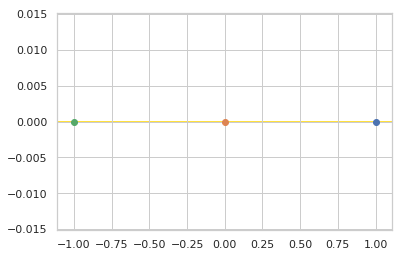

In [60]:
fig, ax = plt.subplots()
ax.axhline(y=0,c="gold",zorder=-1)

for x in v1_df["v1"]:
    ax.scatter(x,y=0)
plt.show()

Com base na matriz de distância contruimos o mapa térmico de forma muito simples:

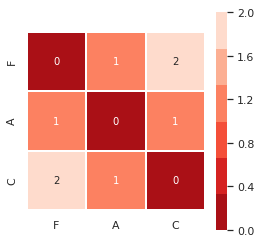

In [61]:
plt.figure(figsize=(4,4))
sns.heatmap(
    v1_distmat,
    cmap=sns.color_palette("Reds_r"),
    linewidth=1,
    annot = True,
    square =True,
)
plt.show()

...e o agrupamento com base nessa matriz:

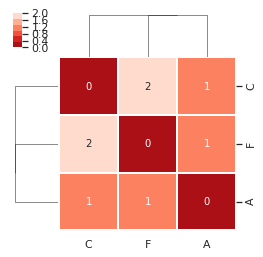

In [62]:
v1_distmat_link = hc.linkage(pdist(v1_df))

sns.clustermap(
    v1_distmat,
    annot = True,
    cmap=sns.color_palette("Reds_r"),
    linewidth=1,
    row_linkage=v1_distmat_link,
    col_linkage=v1_distmat_link,
    figsize=(4,4)
)


### Duas votações, $ n = 2 $

Usando a mesma abordagem (agora sem necessidade de explicações adicionais) adicionamos mais uma votação, sempre em linha com o perfil fixo de votos de cada um: cada partido passa a ter dois votos, logo temos duas dimensões:

In [63]:
v2=[[1,1],[0,0],[-1,-1]]
v2_df = pd.DataFrame(v2, columns=["v1","v2"], index=["F","A", "C"])
v2_df

,v1,v2
F,1,1
A,0,0
C,-1,-1


A distância euclidiana é agora feita de forma mais genérica: a raíz quadrada da soma do quadrado das diferenças: para a primeira diferença isto significa, passo a passo e para $q=F$ e $p=A$:

$ d\left(q,p\right)   = \sqrt {\sum _{i=1}^{n}  \left( q_{i}-p_{i}\right)^2 } = \sqrt{\left( q_{1}-p_{1}\right)^2  + \left( q_{2}-p_{2}\right)^2 } = \sqrt{\left( 1 - 0\right)^2 + \left( 1 - 0\right)^2} = \sqrt{ 1^2  + 1^2 } = \sqrt{1+1} = \sqrt{2} \approx  1.4142135623730951 $

E de facto:

In [64]:
print(math.sqrt(sum((px - qx) ** 2.0 for px, qx in zip(v2_df.loc["F"],v2_df.loc["A"]))))
print(math.sqrt(sum((px - qx) ** 2.0 for px, qx in zip(v2_df.loc["F"],v2_df.loc["C"]))))
print(math.sqrt(sum((px - qx) ** 2.0 for px, qx in zip(v2_df.loc["A"],v2_df.loc["C"]))))

1.4142135623730951
2.8284271247461903
1.4142135623730951


Tal como antes é idêntico ao resultado de `pdist`, tanto na sua forma condensada como quadrada:

In [65]:
print("pdist:\n", pdist(v2),"\n")
print("squareform:\n",squareform(pdist(v2)))
v2_distmat=pd.DataFrame(squareform(pdist(v2)), columns=v2_df.index, index=v2_df.index)
v2_distmat



pdist:
 [1.41421356 2.82842712 1.41421356] 

squareform:
 [[0.         1.41421356 2.82842712]
 [1.41421356 0.         1.41421356]
 [2.82842712 1.41421356 0.        ]]


,F,A,C
F,0.000000,1.414214,2.828427
A,1.414214,0.000000,1.414214
C,2.828427,1.414214,0.000000


Com duas votações temos $ n = 2 $ e conseguimos ver os pontos num espaço cartesiano em $ \mathbb{R}^2 $ (um plano).

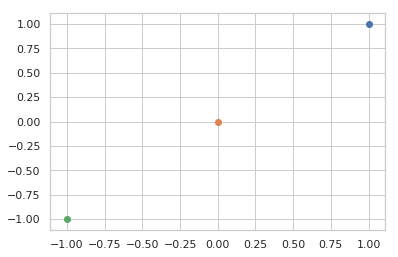

In [66]:
fig, ax = plt.subplots()
for x,y in zip(v2_df["v1"], v2_df["v2"]):
    ax.scatter(x,y)
fig.show()

A matriz de distância seria neste caso, como no anterior, desnecessária (em $ \mathbb{R}^2 $ as distâncias entre os partidos são óbvias por facilmente visualizáveis); a forma de a construir é idêntica:

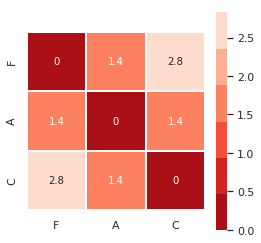

In [67]:
plt.figure(figsize=(4,4))

sns.heatmap(
    v2_distmat,
    cmap=sns.color_palette("Reds_r"),
    linewidth=1,
    annot = True,
    square =True,
)
plt.show()


... e o mapa térmico correspondente:

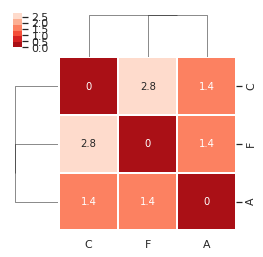

In [68]:
v2_distmat_link = hc.linkage(pdist(v2_df))

sns.clustermap(
    v2_distmat,
    annot = True,
    cmap=sns.color_palette("Reds_r"),
    linewidth=1,
    row_linkage=v2_distmat_link,
    col_linkage=v2_distmat_link,
    figsize=(4,4)
)

### Três votações, $ n = 3 $

Este é o último caso onde a visualização pode ser feita de forma directa. Consideremos:

In [69]:
v3=[[1,1,1],[0,0,0],[-1,-1,-1]]
v3_df = pd.DataFrame(v3, columns=["v1","v2", "v3"], index=["F","A", "C"])
v3_df

,v1,v2,v3
F,1,1,1
A,0,0,0
C,-1,-1,-1


A distância é calculada da mesma forma:

In [70]:
print(math.sqrt(sum((px - qx) ** 2.0 for px, qx in zip(v3_df.loc["F"],v3_df.loc["A"]))))
print(math.sqrt(sum((px - qx) ** 2.0 for px, qx in zip(v3_df.loc["F"],v3_df.loc["C"]))))
print(math.sqrt(sum((px - qx) ** 2.0 for px, qx in zip(v3_df.loc["A"],v3_df.loc["C"]))))

1.7320508075688772
3.4641016151377544
1.7320508075688772


... bem como a matriz de distância:

In [71]:
print("pdist:\n", pdist(v3),"\n")
print("squareform:\n",squareform(pdist(v3)))
v3_distmat=pd.DataFrame(squareform(pdist(v3)), columns=v3_df.index, index=v3_df.index)
v3_distmat

pdist:
 [1.73205081 3.46410162 1.73205081] 

squareform:
 [[0.         1.73205081 3.46410162]
 [1.73205081 0.         1.73205081]
 [3.46410162 1.73205081 0.        ]]


,F,A,C
F,0.000000,1.732051,3.464102
A,1.732051,0.000000,1.732051
C,3.464102,1.732051,0.000000


Estamos agora em $ \mathbb{R}^3 $, e para visualizar podemos usar uma projecção tridimensional:

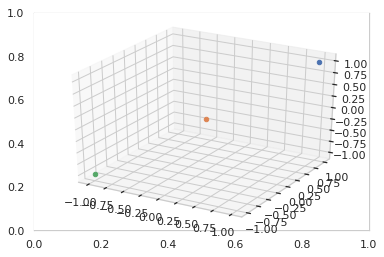

In [72]:
fig, ax = plt.subplots()
ax = fig.add_subplot(111,projection='3d')

for x,y,z in zip(v3_df["v1"], v3_df["v2"], v3_df["v3"]):
    ax.scatter(x,y,z)
fig.show()

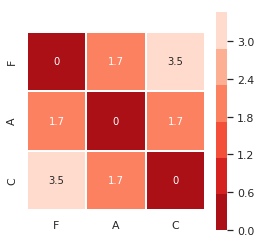

In [73]:
plt.figure(figsize=(4,4))

sns.heatmap(
    v3_distmat,
    cmap=sns.color_palette("Reds_r"),
    linewidth=1,
    annot = True,
    square =True,
)
plt.show()


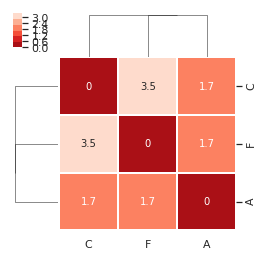

In [74]:
v3_distmat_link = hc.linkage(pdist(v3_df))

sns.clustermap(
    v3_distmat,
    annot = True,
    cmap=sns.color_palette("Reds_r"),
    linewidth=1,
    row_linkage=v3_distmat_link,
    col_linkage=v3_distmat_link,
    figsize=(4,4)
)

### Mais de três votações, $ n > 3 $

A partir daqui coloca-se a questão fundamental: a impossibilidade de visualizar de forma directa a distância para além das três dimensões. A distância existe e segue exactamente os mesmo passos, simplesmente não é passível de visualização, razão pela qual é necessário (agora sim) depender de formas que "reduzam" as dimensões e as tornem visualizáveis.

Até agora os agrupamentos têm sido sempre iguais pois a distância é sempre linear; vamos neste último caso assumir que o Partido Abstencionista teve uma mudança de posição e passou a votar por vezes a favor e contra, embora mais contra que a favor:

In [75]:
v4=[[1,1,1,1,1,1,1,1,1,1],[0,0,0,1,0,-1,0,-1,-1,-1],[-1,-1,-1,-1,-1,-1,-1,-1,-1,-1]]
v4_df = pd.DataFrame(v4, columns=["v1","v2", "v3","v4","v5","v6","v7","v8","v9","v10"], index=["F","A", "C"])
v4_df

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10
F,1,1,1,1,1,1,1,1,1,1
A,0,0,0,1,0,-1,0,-1,-1,-1
C,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


A distância calculdada "manualmente":

In [76]:
print(math.sqrt(sum((px - qx) ** 2.0 for px, qx in zip(v4_df.loc["F"],v4_df.loc["A"]))))
print(math.sqrt(sum((px - qx) ** 2.0 for px, qx in zip(v4_df.loc["F"],v4_df.loc["C"]))))
print(math.sqrt(sum((px - qx) ** 2.0 for px, qx in zip(v4_df.loc["A"],v4_df.loc["C"]))))

4.58257569495584
6.324555320336759
3.0


... e o cálculo via `pdist` e a  matriz de distância:

In [77]:
print("pdist:\n", pdist(v4),"\n")
print("squareform:\n",squareform(pdist(v4)))
v4_distmat=pd.DataFrame(squareform(pdist(v4)), columns=v4_df.index, index=v4_df.index)
v4_distmat

pdist:
 [4.58257569 6.32455532 3.        ] 

squareform:
 [[0.         4.58257569 6.32455532]
 [4.58257569 0.         3.        ]
 [6.32455532 3.         0.        ]]


,F,A,C
F,0.000000,4.582576,6.324555
A,4.582576,0.000000,3.000000
C,6.324555,3.000000,0.000000


O mapa térmico:

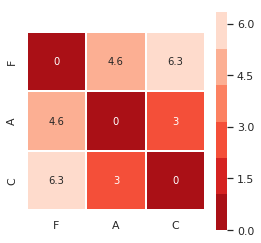

In [78]:
plt.figure(figsize=(4,4))

sns.heatmap(
    v4_distmat,
    cmap=sns.color_palette("Reds_r"),
    linewidth=1,
    annot = True,
    square =True,
)
plt.show()


... e o dendograma, já apresentando um agrupamento com base na maior aproximação com base no registo de votação:

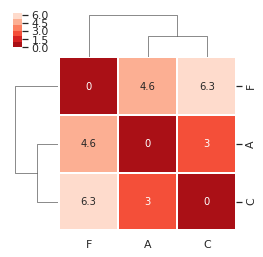

In [79]:
v4_distmat_link = hc.linkage(pdist(v4_df), method="ward")

sns.clustermap(
    v4_distmat,
    annot = True,
    cmap=sns.color_palette("Reds_r"),
    linewidth=1,
    row_linkage=v4_distmat_link,
    col_linkage=v4_distmat_link,
    figsize=(4,4)
)

### Métodos de _clustering_

Da mesma forma que podemos especificar diferentes métricas de distância, podemos também especificar diferentes métodos de agregação, que com base na distância entre os vários pontos vão determinar de que forma podem ser agrupados: de que forma se determina a ligação entre eles.

O valor por omissão usado pela função `linkage` o da ligação `simple`, determinada pela distância mínima entre os pontos mais próximos  $ \min \,\{\,d(a,b):a\in A,\,b\in B\,\} $; uma alternativa bastante comum e que determina os _cluster_ com base na distância média é o `average` (também conhecido por UPGMA), e outra é o método de Ward [14WardMethod].

Podemos ver a diferença entre os três com o seguinte exemplo; adicionamos um partido ("B") normalmente se abstem mas vota duas vezes de forma diferente, ambas em sentido oposto ao partido "A".

In [80]:
v5=[[1,1,1,1,1,1,1,1,1,1],[0,0,0,1,0,-1,0,-1,-1,-1],[0,0,0,-1,0,0,0,0,0,1],[-1,-1,-1,-1,-1,-1,-1,-1,-1,-1]]

v5_df = pd.DataFrame(v5, columns=["v1","v2", "v3","v4","v5","v6","v7","v8","v9","v10"], index=["F","A","B" ,"C"])
v5_distmat=pd.DataFrame(squareform(pdist(v5)), columns=v5_df.index, index=v5_df.index)
v5_distmat

,F,A,B,C
F,0.000000,4.582576,3.464102,6.324555
A,4.582576,0.000000,3.316625,3.000000
B,3.464102,3.316625,0.000000,3.464102
C,6.324555,3.000000,3.464102,0.000000


Usando o método simples obtemos o seguinte dendograma:

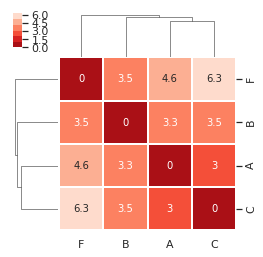

In [81]:
v5_distmat_link = hc.linkage(pdist(v5_df))

sns.clustermap(
    v5_distmat,
    annot = True,
    cmap=sns.color_palette("Reds_r"),
    linewidth=1,
    row_linkage=v5_distmat_link,
    col_linkage=v5_distmat_link,
    figsize=(4,4)
)

Usando UPGMA não há alterações (neste caso muito simples, porque o mais provável é existirem quando aplicadas a dados reais com maior número de observações e dimensões); os agrupamentos tendem a ser feitos de forma recursiva, por separação de elementos individuais até à identificação de um par final:

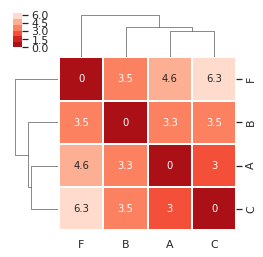

In [82]:
v5_distmat_link = hc.linkage(pdist(v5_df), method="average")

sns.clustermap(
    v5_distmat,
    annot = True,
    cmap=sns.color_palette("Reds_r"),
    linewidth=1,
    row_linkage=v5_distmat_link,
    col_linkage=v5_distmat_link,
    figsize=(4,4)
)

Com o método de Ward o resultado não é muito diferente mas tende a agrupar em _clusters_ de número e dimensões iguais e é por isso uma escolha muito popular [morseReducingSizeNondominated1980]; neste caso cria dois grupos de dois elementos, agrupando o novo partido pela consideração que faz das destâncias entre todos:

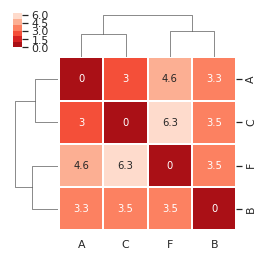

In [83]:
v5_distmat_link = hc.linkage(pdist(v5_df), method="ward")

sns.clustermap(
    v5_distmat,
    annot = True,
    cmap=sns.color_palette("Reds_r"),
    linewidth=1,
    row_linkage=v5_distmat_link,
    col_linkage=v5_distmat_link,
    figsize=(4,4)
)

### Um exemplo simples de MDS

Consideremos uma votação como a seguinte, onde os 4 partidos têm um perfil de votação simples que torna simples adivinhar os agrupamentos: entre o que vota sempre a favor e o que vota sempre contra temos partidos que metade das vezes se abstêm e a outra metade votam de forma diferente; a matriz de distância correspondente:

In [84]:
v6=[[1,1,1,1,1,1,1,1,1,1],[1,0,1,0,1,0,1,0,1,0],[0,-1,0,-1,0,-1,0,-1,0,-1],[-1,-1,-1,-1,-1,-1,-1,-1,-1,-1]]

v6_df = pd.DataFrame(v6, columns=["v1","v2", "v3","v4","v5","v6","v7","v8","v9","v10"], index=["F","A","B" ,"C"])
v6_distmat=pd.DataFrame(squareform(pdist(v6)), columns=v6_df.index, index=v6_df.index)
v6_distmat

,F,A,B,C
F,0.000000,2.236068,5.000000,6.324555
A,2.236068,0.000000,3.162278,5.000000
B,5.000000,3.162278,0.000000,2.236068
C,6.324555,5.000000,2.236068,0.000000


Com estas distâncias conseguimos, através de MDS, reduzir o número de dimensões de forma a podermos visualizar o resultado:

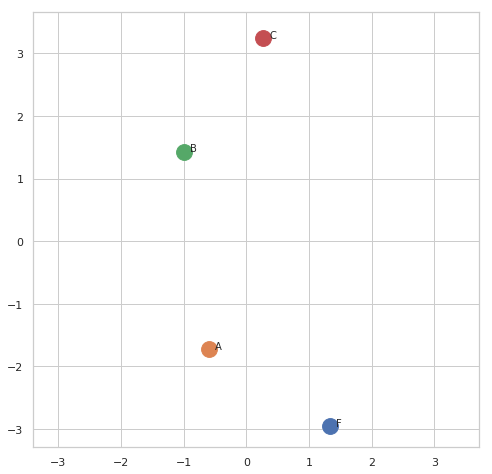

In [85]:
from sklearn.manifold import MDS
import random

mds = MDS(n_components=2, dissimilarity='precomputed',random_state=2020, n_init=100, max_iter=1000)

results = mds.fit(v6_distmat.values)
coords = results.embedding_
fig, ax = plt.subplots(figsize=(8,8))

for label, x, y in zip(v6_distmat.columns, coords[:, 0], coords[:, 1]):
    ax.scatter(x, y, s=250)
    ax.axis('equal')
    ax.annotate(
        label,
        xy = (x+0.1, y),
    )
plt.show()


Observe-se que não temos agrupamentos: MDS não é um método de _clustering_ mas sim de redução das dimensões de forma a manter as distâncias relativas entre os vários pontos, o que nos permite identificar visualmente possíveis grupos (neste caso parece claro que $\{C,B\}$ e $\{A,F\}$ são grupos que se destacam pela proximidade edos seus elementos e distância entre si).

### Spectrum Scaling

Este método é, como referido, uma das formas de se poder proceder à identificação automática de _clusters_, tendo como base uma matriz de afinidade <cite data-cite="1084038/HX4BMSIN"></cite>

In [86]:
v6_distmat_mm=((v6_distmat-v6_distmat.min().min())/(v6_distmat.max().max()-v6_distmat.min().min()))*1

pd.DataFrame(1-v6_distmat_mm, v6_distmat.index, v6_distmat.columns)


,F,A,B,C
F,1.000000,0.646447,0.209431,0.000000
A,0.646447,1.000000,0.500000,0.209431
B,0.209431,0.500000,1.000000,0.646447
C,0.000000,0.209431,0.646447,1.000000


Um parâmetros fundamental é o número de _clusters_ a identificar; neste caso indicamos dois:

In [87]:
v6_sc = SpectralClustering(2, affinity="precomputed",random_state=2020).fit_predict(1 - v6_distmat_mm)
v6_sc_dict = dict(zip(v6_distmat,v6_sc))
print(v6_sc_dict)

{'F': 1, 'A': 1, 'B': 0, 'C': 0}


O MDS correspondente:

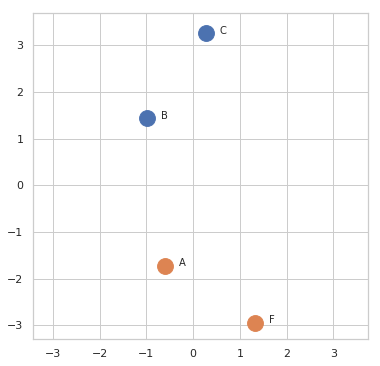

In [88]:
fig, ax = plt.subplots(figsize=(6,6))

for label, x, y in zip(v6_distmat.columns, coords[:, 0], coords[:, 1]):
    ax.scatter(x, y, c = "C"+str(v6_sc_dict[label]), s=250)
    ax.axis('equal')
    ax.annotate(
        label,xy = (x+0.3, y),)


## DBSCAN

Este método dispensa a inicialização com o número de grupos <cite data-cite="1084038/PF2IFXA5"></cite>:

In [89]:
from sklearn.cluster import DBSCAN

dbscan_labels = DBSCAN(min_samples=2,eps=0.7).fit((1 - v6_distmat_mm))
dbscan_labels.labels_
v6_dbscan_dict = dict(zip(v6_distmat_mm,dbscan_labels.labels_))
v6_dbscan_dict

{'F': 0, 'A': 0, 'B': 1, 'C': 1}

Neste caso específico o resultado é idêntico:

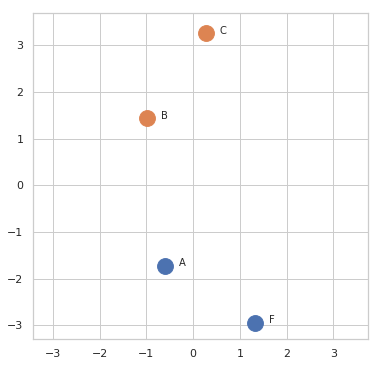

In [90]:
fig, ax = plt.subplots(figsize=(6,6))

for label, x, y in zip(v6_distmat.columns, coords[:, 0], coords[:, 1]):
    ax.scatter(x, y, c = "C"+str(v6_dbscan_dict[label]), s=250)
    ax.axis('equal')
    ax.annotate(
        label,xy = (x+0.3, y),)

## Deputada Cristina Rodrigues e o PAN


Como referido optámos por não incluir a deputação não-inscrita Cristina Rodrigues na análise principal, essencialmente pela mais reduzida quantidade de votações. Fazemos aqui, contudo, duas análises de detalhes de forma a permitir uma leitura específica desta situação.

### Comparação com todas as votações, assumindo votos do PAN

Neste caso assumimos que os votos da deputada são os mesmos do PAN antes da sua saída (condensamos todos os passos necessário para a construção da matriz de distância e dendograma num único bloco, seguindo-se as restantes análises sem explicações adicionais por redundantes):

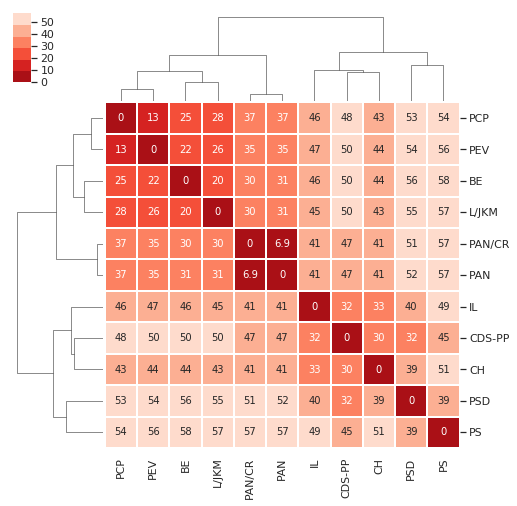

In [91]:
cr_votes_hm = votes[['BE', 'PCP', 'PEV', 'L/JKM', 'PS', 'PAN','PAN/CR','PSD','IL','CDS-PP', 'CH']]
cr_votes_hmn = cr_votes_hm.replace(["A Favor", "Contra", "Abstenção", "Ausência"], [1,-1,0,0]).fillna(0)


## Transpose the dataframe used for the heatmap
cr_votes_t = cr_votes_hmn.transpose()

## Determine the Eucledian pairwise distance
## ("euclidean" is actually the default option)
cr_pwdist = pdist(cr_votes_t, metric='euclidean')

## Create a square dataframe with the pairwise distances:
## the distance matrix
cr_distmat = pd.DataFrame(
    squareform(cr_pwdist), # pass a symmetric distance matrix
    columns = cr_votes_t.index,
    index = cr_votes_t.index
)
## Perform hierarchical linkage on the distance matrix using Ward's method.
cr_distmat_link = hc.linkage(cr_pwdist, method="ward", optimal_ordering=True )
#plt.figure(figsize=(8,8))

sns.clustermap(
    cr_distmat,
    annot = True,
    cmap=sns.color_palette("Reds_r"),
    linewidth=1,
    #standard_scale=1,
    row_linkage=cr_distmat_link,
    col_linkage=cr_distmat_link,
    figsize=(8,8)
)

plt.show()

#### Spectrum Clustering

Aplicando _Spectrum Clustering_ aos dados obtemos a seguinte classificação de _clusters_:

In [92]:
cr_distmat_mm=((cr_distmat-cr_distmat.min().min())/(cr_distmat.max().max()-cr_distmat.min().min()))*1

cr_affinmat_mm = pd.DataFrame(1-cr_distmat_mm, cr_distmat.index, cr_distmat.columns)
cr_sc = SpectralClustering(5, affinity="precomputed",random_state=2020).fit_predict(cr_affinmat_mm)
cr_sc_dict = dict(zip(cr_distmat,cr_sc))
cr_sc_dict 

{'BE': 3,
 'PCP': 4,
 'PEV': 4,
 'L/JKM': 3,
 'PS': 1,
 'PAN': 0,
 'PAN/CR': 0,
 'PSD': 1,
 'IL': 2,
 'CDS-PP': 2,
 'CH': 2}

#### _Multi Dimension Scaling_

O gráfico de MDS com a inclusão da deputada Cristina Rodrigues é o seguinte:


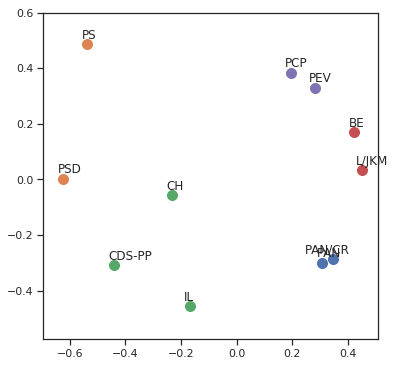

In [93]:
cr_mds = MDS(n_components=2, dissimilarity='precomputed',random_state=2020, n_init=100, max_iter=1000)
cr_results = mds.fit(cr_distmat_mm.values)
cr_coords = cr_results.embedding_

sns.set()
sns.set_style("ticks")


fig, ax = plt.subplots(figsize=(6,6))

#fig.suptitle('Portuguese Parliament Voting Records Analysis, 14th Legislature\nMDS with Spectrum Clustering clusters, inc. Cristina Rodrigues (2D)', fontsize=14)
#plt.title('MDS with Spectrum Clustering clusters, inc. Cristina Rodrigues (2D)')

for label, x, y in zip(cr_distmat_mm.columns, cr_coords[:, 0], cr_coords[:, 1]):
    ax.scatter(x, y, c = "C"+str(cr_sc_dict[label]), s=100)
    ax.axis('equal')
    if label=="PAN/CR":
        ax.annotate(label,xy = (x-0.10, y+0.020))
    else:
        ax.annotate(label,xy = (x-0.02, y+0.020))

plt.show()

Como podemos observar as diferenças são bastante pequenas, o que tendo em conta o (relativamente) pequeno número de votações feitas de forma individual não é de estranhar, em especial quando existem também muitos casos onde são idênticos, e onde são diferentes normalmente a diferença é a mínima (i.e. são raras situações de votos A Favor/Contra, que têm maior distância):

Voted the same: 379
Voted differently: 34


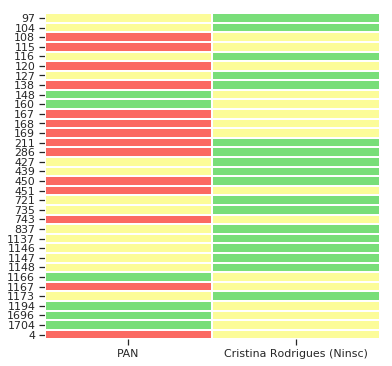

In [94]:
cr_pan_comp = votes[[ 'PAN','PAN/CR','Cristina Rodrigues (Ninsc)']]
cr_pan_comp = cr_pan_comp.dropna().replace(["A Favor", "Contra", "Abstenção", "Ausência"], [1,-1,0,0])
voting_palette = ["#FB6962","#FCFC99","#79DE79", "black"]
cr_pan_diff = cr_pan_comp[["PAN","Cristina Rodrigues (Ninsc)"]].dropna()[cr_pan_comp["PAN"] != cr_pan_comp["Cristina Rodrigues (Ninsc)"]]
cr_pan_same= cr_pan_comp[["PAN","Cristina Rodrigues (Ninsc)"]].dropna()[cr_pan_comp["PAN"] == cr_pan_comp["Cristina Rodrigues (Ninsc)"]]

print("Voted the same:", cr_pan_same.shape[0])
print("Voted differently:",cr_pan_diff.shape[0])

fig, ax = plt.subplots(figsize=(6,6))
sns.set(color_codes=True)

## Build a heatmap of the vote when they diverged
#fig.suptitle('Portuguese Parliament Voting Records Analysis, 14th Legislature', fontsize=14)
#ax.set_title('PAN and Cristina Rodrigues voting record (only where they diverge)')
sns.heatmap(cr_pan_diff.astype(float) , cbar=False,yticklabels = True, cmap=sns.color_palette(palette=["#FB6962","#FCFC99","#79DE79"]), linewidth=1)
plt.show()

### Utilização apenas das votações da deputada Cristina Rodrigues enquanto deputada não-inscrita

Se reduzirmos a análise apenas às votações onde a deputada Cristina Rodrigues participou como deputda não inscrita temos o seguinte resultado, que não altera de forma substancial o que já foi apresentado:

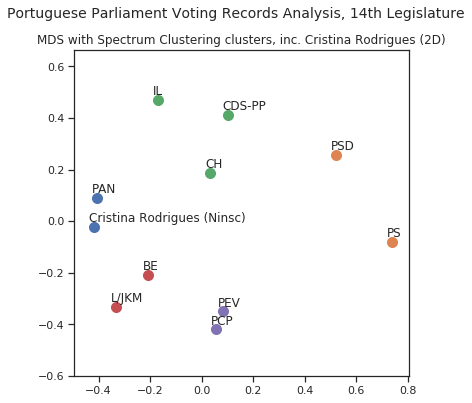

In [95]:
cr_only_votes_hm = votes[['BE', 'PCP', 'PEV', 'L/JKM', 'PS', 'PAN',"Cristina Rodrigues (Ninsc)",'PSD','IL','CDS-PP', 'CH']]
cr_only_votes_hmn = cr_only_votes_hm.replace(["A Favor", "Contra", "Abstenção", "Ausência"], [1,-1,0,0]).dropna()

## Transpose the dataframe used for the heatmap
cr_only_votes_t = cr_only_votes_hmn.transpose()

## Determine the Eucledian pairwise distance
## ("euclidean" is actually the default option)
cr_only_pwdist = pdist(cr_only_votes_t, metric='euclidean')

## Create a square dataframe with the pairwise distances:
## the distance matrix
cr_only_distmat = pd.DataFrame(
    squareform(cr_only_pwdist), # pass a symmetric distance matrix
    columns = cr_only_votes_t.index,
    index = cr_only_votes_t.index
)
cr_only_distmat_link = hc.linkage(cr_only_pwdist, method="ward", optimal_ordering=True )

## Normalise
cr_only_distmat_mm=((cr_only_distmat-cr_only_distmat.min().min())/(cr_only_distmat.max().max()-cr_only_distmat.min().min()))*1


## SC

cr_only_affinmat_mm = pd.DataFrame(1-cr_only_distmat_mm, cr_only_distmat.index, cr_only_distmat.columns)
cr_only_sc = SpectralClustering(5, affinity="precomputed",random_state=2020).fit_predict(cr_only_affinmat_mm)
cr_only_sc_dict = dict(zip(cr_only_distmat,cr_only_sc))
cr_only_sc_dict 

## MDS
cr_only_mds = MDS(n_components=2, dissimilarity='precomputed',random_state=2020, n_init=100, max_iter=1000)
cr_only_results = mds.fit(cr_only_distmat_mm.values)
cr_only_coords = cr_only_results.embedding_

## Plot it
sns.set()
sns.set_style("ticks")

fig, ax = plt.subplots(figsize=(6,6))

fig.suptitle('Portuguese Parliament Voting Records Analysis, 14th Legislature', fontsize=14)
ax.set_title('MDS with Spectrum Clustering clusters, inc. Cristina Rodrigues (2D)')

for label, x, y in zip(cr_only_distmat_mm.columns, cr_only_coords[:, 0], cr_only_coords[:, 1]):
    ax.scatter(x, y, c = "C"+str(cr_only_sc_dict[label]), s=100)
    #ax.scatter(x, y, s=100)
    ax.axis('equal')
    if label=="PAN/CR":
        ax.annotate(label,xy = (x-0.10, y+0.020))
    else:
        ax.annotate(label,xy = (x-0.02, y+0.020))

plt.show()

... e a respectiva matriz de distância:

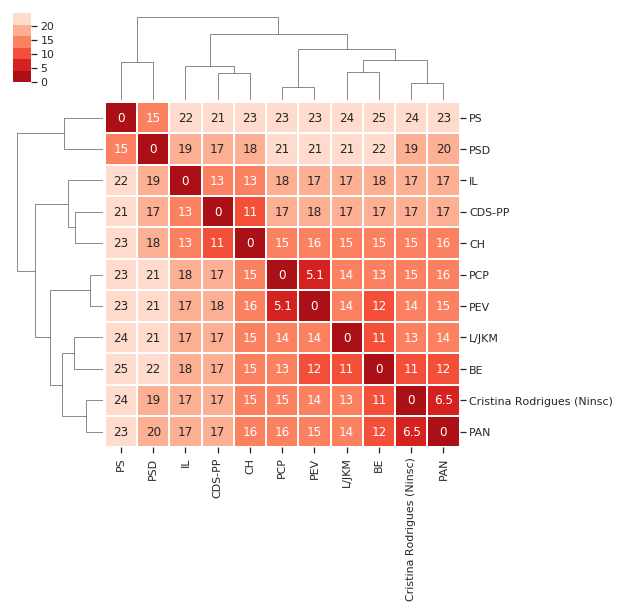

In [96]:
sns.clustermap(
    cr_only_distmat,
    annot = True,
    cmap=sns.color_palette("Reds_r"),
    linewidth=1,
    #standard_scale=1,
    row_linkage=cr_only_distmat_link,
    col_linkage=cr_only_distmat_link,
    figsize=(8,8)
)

plt.show()

------------
**2020, Frederico Muñoz**